<table class="table table-bordered">
    <tr>
        <th style="width:250px;">
            <img src='https://bcgriseacademy.com/hs-fs/hubfs/rise2.0_black_logo.png' style="background-color:white; width: 100%; height: 100%; padding: 20px">
        </th>
        <th style="text-align:center;">
            <h1>M2 Assessment</h1>
            <h3>IBF TFIP</h3>
        </th>
    </tr>
</table>

## Know the context

You are a data analyst working in one of the largest banks by assets in Southeast Asia, where the bank is also the largest payment bank in terms of transaction value.

The bank intends to analyse and prevent the CASA portfolio attrition of corporate customers by identifying declining customer relationship (i.e., soft churn) 3 months in advance.


## Business problem

- Declining year-on-year CASA balance, resulting in low profits across segments of customers. This is coupled with the bank losing market share to competitors

## Project objectives and description

- Build a predictive model to identify corporate customers who are likely to soft churn.

## Assessment Objectives
- Apply the techniques involved in end-to-end predictive modelling (e.g., data preparation, feature engineering and selection, model building and tuning, model evaluation etc.)
- Interpret model findings and translate them into business insights

## Things to Note
- This is a guided assessment where you will be asked to enter code in areas for which you would have already learnt in the classroom sessions
- The goal of this project is to illustrate the framework of what a relatively straightforward predictive modelling project looks like. You will also notice that the data processing and feature engineering part takes up the most effort and time, which is reflective of real world situations.

___
## (1) Initial Setup
- Start by importing the necessary libraries and datasets

In [1]:
import os

# for data manipulation
import math
import pandas as pd
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import numpy as np
from numpy.polynomial import Polynomial

# for data visualization
import matplotlib.pyplot as plt

# for machine learning
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

# for model evaluation
from sklearn import metrics
from sklearn.metrics import (accuracy_score, precision_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve, average_precision_score, f1_score, 
                             ConfusionMatrixDisplay)


# for warnings
import warnings
warnings.filterwarnings("ignore")

#### (1.1) Import the 4 datasets as pandas DataFrames
- Store them using the following 4 variables: `funding`, `lending`, `transactions`, and `feedback`

In [2]:
# LEARNER TODO
df_list = []

for root, dirs, files in os.walk('Data/'):
    for i,file in enumerate(files):
        # Read the file into a data frame and append it to the list of data frames
        df = pd.read_csv(os.path.join(root, file))
        df_list.append(df)
        print(i, file, "loaded")

0 Feedback_2017_2019.csv loaded
1 Funding_2017_2019.csv loaded
2 Lending_2017_2019.csv loaded
3 Transactions_2017_2019.csv loaded


In [3]:
feedback, funding, lending, transactions = df_list[0], df_list[1], df_list[2], df_list[3]

#### (1.2) View the first 5 rows for each dataset

In [4]:
# LEARNER TODO
feedback.head()

,CUSTOMER_ID,PERIOD,FEEDBACK
0,6069045,201802,2
1,6410737,201911,4
2,5426241,201710,2
3,1044700,201711,4
4,6195462,201810,2


In [5]:
# LEARNER TODO
funding.head()

,PERIOD,CUSTOMER_ID,ACCOUNT_ID,CUSTOMER_JOIN_DATE,SECTOR_L1,SECTOR_L2,END_BALANCE
0,201701,21467.0,39504628.0,201409.0,Services ...,Business & Social Services - Business Services...,2.178537e+08
1,201701,22565.0,39483529.0,201410.0,Real Estate ...,Commercial Property - Retail ...,1.356674e+07
2,201701,24348.0,39071537.0,201410.0,Mining & Quarrying ...,Iron & Steel - Manufacturing ...,2.775962e+07
3,201701,26954.0,39300194.0,201410.0,Real Estate ...,Residential Property - House ...,0.000000e+00
4,201701,26958.0,19954812.0,201410.0,Real Estate ...,Residential Property - House ...,0.000000e+00


In [6]:
# LEARNER TODO
lending.head()

,PERIOD,CUSTOMER_ID,ACCOUNT_ID,CL_MATURITY_DATE,CL_DIRECTORATE,GIRO_OVERDRAFT_FLAG,CR_OUTSTANDING
0,201704,5413547,28538138,24/6/2017 0:00,CORPORATE BANKING,0,3.096671e+08
1,201704,4043411,2390605,14/8/2017 0:00,COMMERCIAL BANKING,0,2.000000e+09
2,201704,4043411,2386858,14/8/2017 0:00,COMMERCIAL BANKING,0,4.000000e+09
3,201704,4043411,2387433,14/8/2017 0:00,COMMERCIAL BANKING,0,4.800000e+09
4,201704,7393273,26691561,9/5/2017 0:00,COMMERCIAL BANKING,0,0.000000e+00


In [7]:
# LEARNER TODO
transactions.head()

,PERIOD,CUSTOMER_ID,ACCOUNT_ID,TRANSACTION_TYPE,VOLUME_TRANSACTED
0,201701,57396.0,6015162.0,Charges - D,30000.0030000.00
1,201701,87996.0,6132843.0,Bill Payment - D,4701618.004701618.00
2,201701,124409.0,14954823.0,Charges - D,30000.0030000.00
3,201701,124409.0,14962971.0,Charges - D,30000.0030000.00
4,201701,159663.0,6022161.0,Overbooking - D,12000.0012000.00


#### Further Context on Datasets
- The full set of corporate customers (having CASA accounts) along with their corresponding firmographics and balances is found in the `funding` dataset
- The customers' utilization of banking services can be found in the `transactions` dataset (e.g., bill payment, debit charges)
- Only a subset of customers with CASA accounts have taken a loan from the bank as well (information in the `lending` dataset)
- Only a subset of customers with CASA accounts have provided feedback on the banking experience (information in the `feedback` dataset)

___
## (2) Exploratory Data Analysis
___
#### (2.1) Based on what you have learnt previously, perform a series of standard EDA to gain a better understanding of the 4 datasets

In [8]:
df_names = ['feedback', 'funding', 'lending', 'transactions']

In [9]:
#info
for name, df in zip(df_names, df_list):
    print(f"*****{name}*****")
    print(df.info())

*****feedback*****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12126 entries, 0 to 12125
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   CUSTOMER_ID  12126 non-null  int64
 1   PERIOD       12126 non-null  int64
 2   FEEDBACK     12126 non-null  int64
dtypes: int64(3)
memory usage: 284.3 KB
None
*****funding*****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216520 entries, 0 to 1216519
Data columns (total 7 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   PERIOD              1216520 non-null  int64  
 1   CUSTOMER_ID         1216520 non-null  float64
 2   ACCOUNT_ID          1216520 non-null  float64
 3   CUSTOMER_JOIN_DATE  1181201 non-null  float64
 4   SECTOR_L1           1216333 non-null  object 
 5   SECTOR_L2           1216333 non-null  object 
 6   END_BALANCE         1216520 non-null  float64
dtypes: float64(4), int64(1), object(2)

In [10]:
#describe
feedback.describe().T

,count,mean,std,min,25%,50%,75%,max
CUSTOMER_ID,12126.0,5.759698e+06,3.803541e+06,3205.0,2585004.75,5262939.0,7755967.5,13876844.0
PERIOD,12126.0,2.018059e+05,8.133516e+01,201701.0,201710.00,201806.0,201904.0,201912.0
FEEDBACK,12126.0,3.001979e+00,1.409890e+00,1.0,2.00,3.0,4.0,5.0


In [11]:
funding.describe().T

,count,mean,std,min,25%,50%,75%,max
PERIOD,1216520.0,2.018029e+05,8.157067e+01,201701.0,201709.00,201806.0,201903.0,2.019120e+05
CUSTOMER_ID,1216520.0,4.683070e+06,3.011645e+06,112.0,2439269.00,4274908.0,6509267.0,1.309617e+07
ACCOUNT_ID,1216520.0,1.921537e+07,1.402211e+07,586.0,6028672.00,15813605.0,33292672.0,4.227174e+07
CUSTOMER_JOIN_DATE,1181201.0,2.007014e+05,8.097670e+02,195509.0,200303.00,200812.0,201309.0,2.018120e+05
END_BALANCE,1216520.0,2.597760e+09,3.400560e+10,-938700000.0,47803.19,20128600.7,282200000.0,6.961256e+12


In [12]:
lending.describe().T

,count,mean,std,min,25%,50%,75%,max
PERIOD,256756.0,2.018233e+05,7.892672e+01,201704.00,201801.0,2.018090e+05,2.019060e+05,2.019120e+05
CUSTOMER_ID,256756.0,4.763276e+06,3.132886e+06,18208.00,1860357.0,4.524623e+06,6.693984e+06,1.310331e+07
ACCOUNT_ID,256756.0,2.885335e+07,1.295682e+07,2034.00,28479256.0,3.339440e+07,3.863743e+07,4.216179e+07
GIRO_OVERDRAFT_FLAG,256756.0,9.384007e-02,2.916067e-01,0.00,0.0,0.000000e+00,0.000000e+00,1.000000e+00
CR_OUTSTANDING,256756.0,1.207955e+10,5.810146e+10,-0.01,362823000.0,1.473287e+09,5.000000e+09,4.000000e+12


In [13]:
transactions.describe().T

,count,mean,std,min,25%,50%,75%,max
PERIOD,2822680.0,2.018092e+05,8.160172e+01,201701.0,201710.0,201807.0,201904.0,201912.0
CUSTOMER_ID,2822680.0,4.806964e+06,3.027181e+06,3205.0,2481456.0,4645703.0,6651200.0,13090456.0
ACCOUNT_ID,2822680.0,1.220732e+07,1.094127e+07,156058.0,6000225.0,6163769.0,15935070.0,42271371.0


In [14]:
#missing values
for name, df in zip(df_names, df_list):
    print(f"*****{name}*****")
    print(df.isna().sum())

*****feedback*****
CUSTOMER_ID    0
PERIOD         0
FEEDBACK       0
dtype: int64
*****funding*****
PERIOD                    0
CUSTOMER_ID               0
ACCOUNT_ID                0
CUSTOMER_JOIN_DATE    35319
SECTOR_L1               187
SECTOR_L2               187
END_BALANCE               0
dtype: int64
*****lending*****
PERIOD                 0
CUSTOMER_ID            0
ACCOUNT_ID             0
CL_MATURITY_DATE       1
CL_DIRECTORATE         0
GIRO_OVERDRAFT_FLAG    0
CR_OUTSTANDING         0
dtype: int64
*****transactions*****
PERIOD               0
CUSTOMER_ID          0
ACCOUNT_ID           0
TRANSACTION_TYPE     0
VOLUME_TRANSACTED    0
dtype: int64


In [15]:
#duplicate values
for name, df in zip(df_names, df_list):
    print(f"*****{name}*****")
    print(df.duplicated().sum())

*****feedback*****
16
*****funding*****
102
*****lending*****
0
*****transactions*****
15593


___
> ## Important Details of Business Context

- Before pre-processing the data, let us understand the project context on a deeper level
- As part of the project scoping, we want to build a predictive model for corporate customers who newly joined the bank as a customer in the years 2017 and 2018 i.e. `CUSTOMER_JOIN_DATE` between Jan 2017 and Dec 2018
- For each of these new joiner customers, we want to analyze their behavior and profiles for the first 6 months since joining (i.e., months 1 to 6), and predict whether they will soft churn in the following 3 months (months 7 to 9)
- Soft churn is defined as a decrease of >=60% from the average CASA fund balance in the first 6 months, as compared to the average CASA fund balance in the latter 3 months

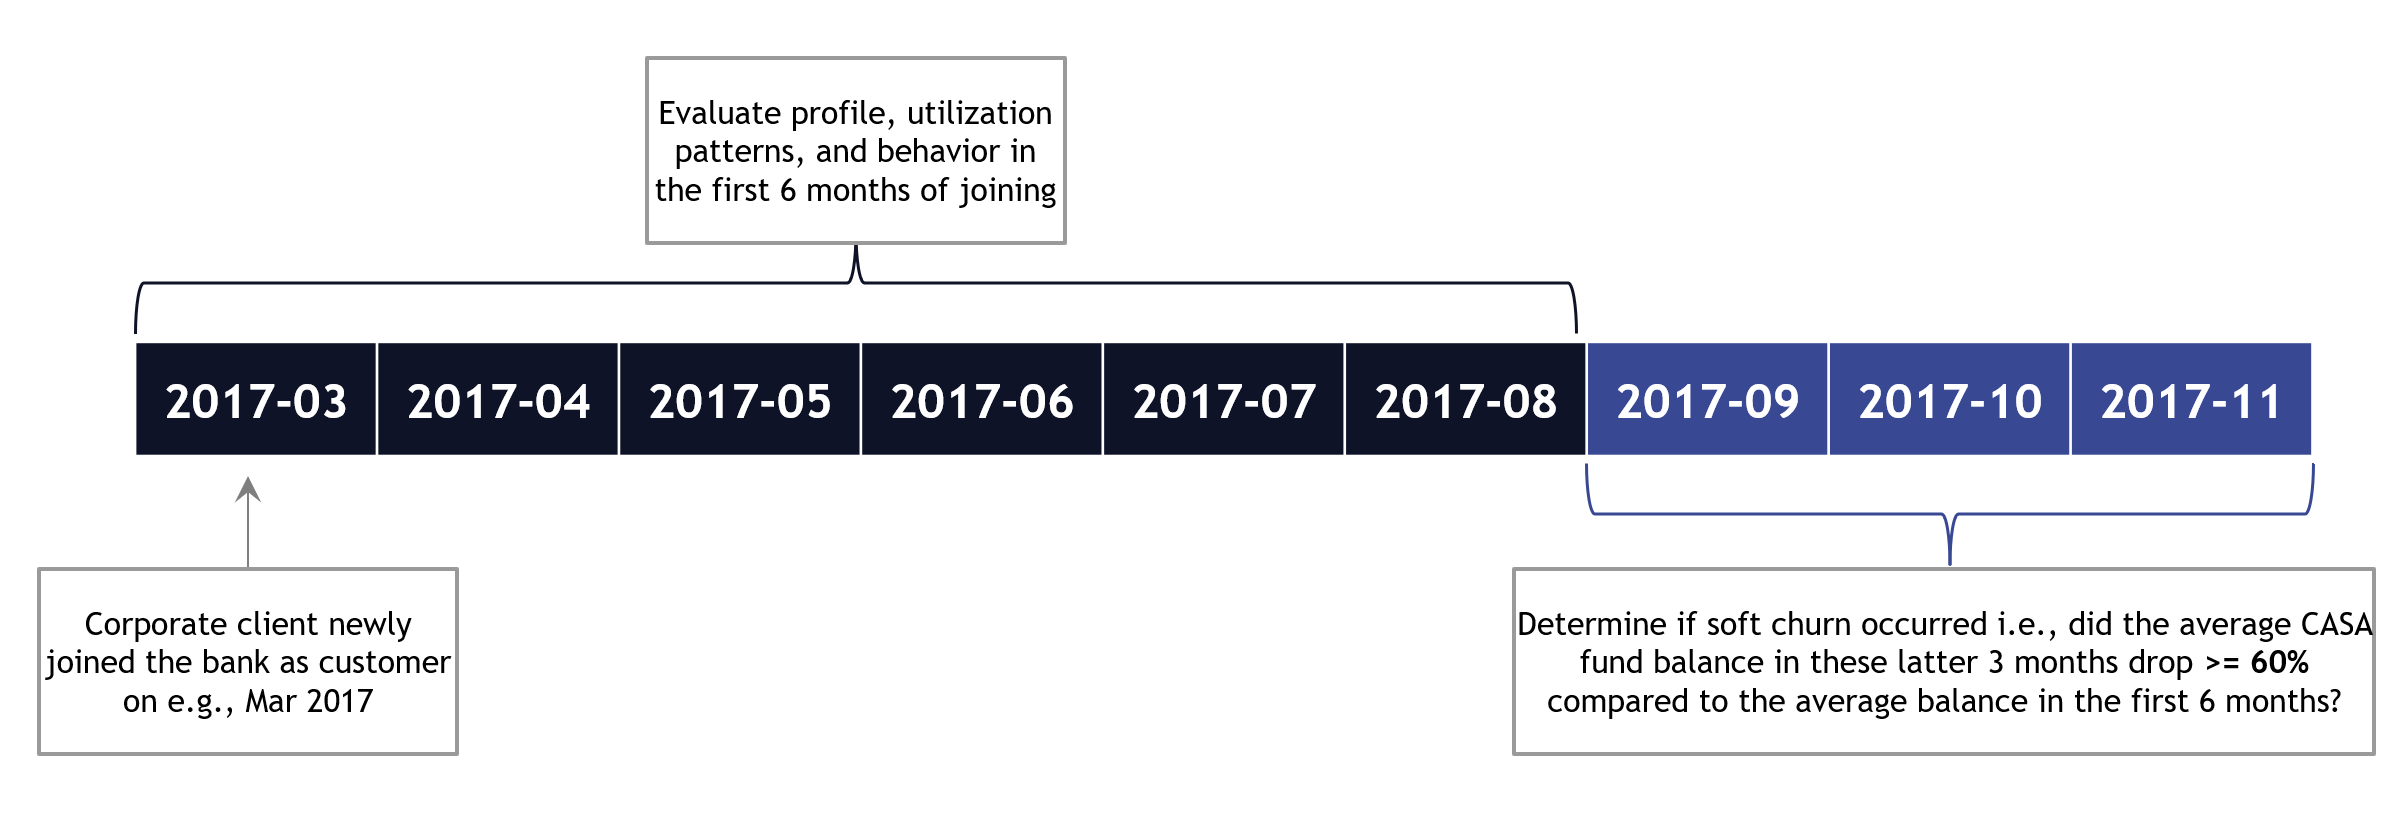

- From the above diagram, we can see that we will be tracking the customer's transactions and banking records for a 9-month window
- Therefore, if the customer joins on December 2018, it means that we will review the customer's records from Dec 2018 to Aug 2019

___
## (3) Data Pre-Processing (Guided section)

- Data processing is a vital part of the analytics workflow
- Besides improving data quality, we also want to filter the data to specific customers whom we wish to analyze

#### Find the list of corporate customers who newly joined the bank as a customer in the years 2017 and 2018 i.e. `CUSTOMER_JOIN_DATE` between Jan 2017 and Dec 2018 (let's call them new joiners)

In [17]:
# Filter to customers who joined the bank in 2017 and 2018
new_joiners = funding[(funding['CUSTOMER_JOIN_DATE'] >= 201701) & (funding['CUSTOMER_JOIN_DATE'] <= 201812)][['CUSTOMER_ID']]
new_joiners_list = new_joiners['CUSTOMER_ID'].unique()

#### Now that we have the list of new joiners whom we want to analyze, we filter the funding records that correspond to this list of new joiners

In [18]:
# Get 2017-2019 funding records of 2017 and 2018 new joiners
new_joiner_funds = funding[funding['CUSTOMER_ID'].isin(new_joiners_list)]

#### (3.1) Convert the columns of `CUSTOMER_ID`, `ACCOUNT_ID`, and `CUSTOMER_JOIN_DATE` into integer type

In [19]:
# LEARNER TODO
# update data types
dtype= {'CUSTOMER_ID'       : 'int64', 
        'ACCOUNT_ID'        : 'int64',
        'CUSTOMER_JOIN_DATE': 'int64'}

new_joiner_funds = new_joiner_funds.astype(dtype)

#### (3.2) View a sample of 10 rows from `new_joiner_funds`

In [20]:
# LEARNER TODO
new_joiner_funds.head(10)

,PERIOD,CUSTOMER_ID,ACCOUNT_ID,CUSTOMER_JOIN_DATE,SECTOR_L1,SECTOR_L2,END_BALANCE
2069,201701,10366474,20088557,201701,Others ...,All other industries not listed above ...,1934000.00
2070,201701,10372601,19131952,201701,Hospitality ...,Accommodation (Operators) ...,80294.00
2071,201701,10375186,19017214,201701,Manufactured Goods ...,Fast Moving Consumer Goods - Manufacturing ...,6454050.00
2072,201701,10375263,19121633,201701,Manufactured Goods ...,Fast Moving Consumer Goods - Manufacturing ...,541622.00
2073,201701,10372912,19034126,201701,Services ...,Tourism & Leisure - Tourism ...,9717497.12
2074,201701,10372912,36046186,201701,Services ...,Tourism & Leisure - Tourism ...,26559871.92
2075,201701,10366487,19069396,201701,Services ...,Tourism & Leisure - Catering / Restaurant ...,15421030.40
2076,201701,10366487,19095387,201701,Services ...,Tourism & Leisure - Catering / Restaurant ...,45866505.82
2077,201701,10371911,19048821,201701,Services ...,Tourism & Leisure - Catering / Restaurant ...,52807752.94
2078,201701,10371911,19110892,201701,Services ...,Tourism & Leisure - Catering / Restaurant ...,20979424.80


___
#### The next step to take is to create a column for our target variable, which is an indicator for soft churn amongst these new joiner customers.

#### We first keep the columns that we want to work on from the `new_joiner_funds` DataFrame. Essentially, we want to keep columns that allows us to compute the average CASA fund balances in the first 6 months, and also in the latter 3 month period.


In [21]:
acct_bal = new_joiner_funds[['CUSTOMER_ID', 'CUSTOMER_JOIN_DATE', 'PERIOD', 'END_BALANCE']]
acct_bal = acct_bal.sort_values(by=['CUSTOMER_ID', 'CUSTOMER_JOIN_DATE', 'PERIOD'])
acct_bal.head(10)

,CUSTOMER_ID,CUSTOMER_JOIN_DATE,PERIOD,END_BALANCE
65873,10315238,201701,201702,10000000.00
76643,10315238,201701,201703,16214077.76
119245,10315238,201701,201704,287697.48
169978,10315238,201701,201705,267697.48
205004,10315238,201701,201706,1555803.62
232990,10315238,201701,201707,135803.62
262616,10315238,201701,201708,115803.62
305542,10315238,201701,201709,3116090.28
338514,10315238,201701,201710,162380.84
365418,10315238,201701,201711,222380.84


#### Group by every period for each unique customer, and sum the fund balance across all the accounts that each unique customer may have. From this, we will obtain the sum of all CASA accounts for each customer for each period

In [22]:
acct_bal_2 = acct_bal.groupby(['CUSTOMER_ID', 'CUSTOMER_JOIN_DATE', 'PERIOD']).sum().reset_index()
acct_bal_2.head(2)

,CUSTOMER_ID,CUSTOMER_JOIN_DATE,PERIOD,END_BALANCE
0,10315238,201701,201702,10000000.00
1,10315238,201701,201703,16214077.76


#### (3.3) We next want to calculate the difference (in months) between the join date and the transaction period. To do this, first convert the two date columns into datetime format.
- HINT: Use `pd.to_datetime`

In [23]:
# LEARNER TODO
# convert to datetime
cols = ['CUSTOMER_JOIN_DATE', 'PERIOD']
acct_bal_2[cols] = acct_bal_2[cols].apply(pd.to_datetime, format='%Y%m')

# check changes
acct_bal_2.head(2)

,CUSTOMER_ID,CUSTOMER_JOIN_DATE,PERIOD,END_BALANCE
0,10315238,2017-01-01,2017-02-01,10000000.00
1,10315238,2017-01-01,2017-03-01,16214077.76


#### Calculate the month difference between the two date columns (rounded to nearest integer)

In [24]:
acct_bal_2['MONTH_DIFF'] = round((acct_bal_2['PERIOD'] - acct_bal_2['CUSTOMER_JOIN_DATE'])/np.timedelta64(1, 'M')).astype(int)

In [25]:
acct_bal_2.head(10)

,CUSTOMER_ID,CUSTOMER_JOIN_DATE,PERIOD,END_BALANCE,MONTH_DIFF
0,10315238,2017-01-01,2017-02-01,10000000.00,1
1,10315238,2017-01-01,2017-03-01,16214077.76,2
2,10315238,2017-01-01,2017-04-01,287697.48,3
3,10315238,2017-01-01,2017-05-01,267697.48,4
4,10315238,2017-01-01,2017-06-01,1555803.62,5
5,10315238,2017-01-01,2017-07-01,135803.62,6
6,10315238,2017-01-01,2017-08-01,115803.62,7
7,10315238,2017-01-01,2017-09-01,3116090.28,8
8,10315238,2017-01-01,2017-10-01,162380.84,9
9,10315238,2017-01-01,2017-11-01,222380.84,10


#### (3.4) Create a new DataFrame variable (named `acct_pre_6m`) by filtering the `acct_bal_3` DataFrame to rows with `MONTH_DIFF` of less than or equal to 5. With that, we will have the funding records in the first 6 months for each customer based on their join date.
- Think about why we filter to <= 5 instead of <= 6.

In [26]:
# LEARNER TODO
# believe acct_bal_3 is a typo and should be 2
acct_pre_6m = acct_bal_2[acct_bal_2['MONTH_DIFF'] <= 5]
acct_pre_6m.head()

,CUSTOMER_ID,CUSTOMER_JOIN_DATE,PERIOD,END_BALANCE,MONTH_DIFF
0,10315238,2017-01-01,2017-02-01,10000000.00,1
1,10315238,2017-01-01,2017-03-01,16214077.76,2
2,10315238,2017-01-01,2017-04-01,287697.48,3
3,10315238,2017-01-01,2017-05-01,267697.48,4
4,10315238,2017-01-01,2017-06-01,1555803.62,5


#### Now that we have the funding records for each customer's first 6 months, we proceed to find the average CASA fund balance in this 6-month period. Also print the first 10 rows of the resulting DataFrame.

In [27]:
cust_pre_mean = acct_pre_6m[['CUSTOMER_ID', 'CUSTOMER_JOIN_DATE','END_BALANCE']].groupby(['CUSTOMER_ID', 'CUSTOMER_JOIN_DATE']).mean().reset_index()
cust_pre_mean = cust_pre_mean.rename(columns={'END_BALANCE':'PRE_6M_MEAN'})
cust_pre_mean.head(10)

,CUSTOMER_ID,CUSTOMER_JOIN_DATE,PRE_6M_MEAN
0,10315238,2017-01-01,5.665055e+06
1,10316279,2017-01-01,9.987000e+06
2,10319623,2017-01-01,2.088438e+08
3,10319739,2017-01-01,2.981871e+08
4,10320347,2017-01-01,6.547267e+06
5,10321652,2017-01-01,5.263484e+05
6,10323713,2017-01-01,6.603265e+04
7,10323927,2017-01-01,3.994145e+05
8,10324687,2017-01-01,3.500002e+05
9,10324935,2017-01-01,1.200395e+05


#### (3.5) Create a new DataFrame variable (named `acct_post_3m`) by filtering the `acct_bal_3` DataFrame to rows with `MONTH_DIFF` of between 6 and 8 (inclusive). With that, we will have the funding records in the latter 3 months (i.e. months 7 to 9) for each customer.

In [28]:
# LEARNER TODO
acct_post_3m = acct_bal_2[(acct_bal_2['MONTH_DIFF']>=6)
                         &(acct_bal_2['MONTH_DIFF']<=8)]
acct_post_3m.head(2)

,CUSTOMER_ID,CUSTOMER_JOIN_DATE,PERIOD,END_BALANCE,MONTH_DIFF
5,10315238,2017-01-01,2017-07-01,135803.62,6
6,10315238,2017-01-01,2017-08-01,115803.62,7


#### (3.6) Now that we have the funding records for months 7 to 9 for each customer, we proceed to find the average CASA fund balance in this 3-month period. Also print the first 10 rows of the resulting DataFrame.
- HINT: Refer above to see how this step was done for the first 6 months
- Name the resulting DataFrame as `cust_post_mean`
- Also rename the end balance column accordingly e.g., POST_3M_MEAN

In [29]:
# LEARNER TODO
cust_post_mean = acct_post_3m[['CUSTOMER_ID', 'CUSTOMER_JOIN_DATE','END_BALANCE']] \
                .groupby(['CUSTOMER_ID', 'CUSTOMER_JOIN_DATE']) \
                .mean() \
                .reset_index()
cust_post_mean = cust_post_mean.rename(columns={'END_BALANCE':'POST_3M_MEAN'})
cust_post_mean.head(10)

,CUSTOMER_ID,CUSTOMER_JOIN_DATE,POST_3M_MEAN
0,10315238,2017-01-01,1.122566e+06
1,10316279,2017-01-01,3.180432e+06
2,10319623,2017-01-01,1.205965e+08
3,10319739,2017-01-01,2.625538e+08
4,10320347,2017-01-01,8.105901e+06
5,10321652,2017-01-01,7.509155e+05
6,10323713,2017-01-01,3.139467e+05
7,10323927,2017-01-01,3.725730e+04
8,10324687,2017-01-01,1.192347e+06
9,10324935,2017-01-01,1.055302e+05


#### With the pre 6-month average balance and post 3-month average balance data available for each of the new joiner customers, we can merge both DataFrames together
- We perform an left join because we only want to keep customers who have non-null values for the prior 6 month period, which reflects active CASA bank account usage.
- It also means that we exclude customers who have null average balance values in the prior 6-month period, as it prevents us from computing whether they underwent soft churn or not
- Note that we will assume that null values in the latter 3-month period refer to a zero balance. While it indicates a hard churn (i.e., customer totally stops using the banking services), it also meets the criteria of soft churn in this case (i.e. decrease in average balance of >= 60%)

In [30]:
# Perform left join with pre-6mth as left table
cust_soft_churn = cust_pre_mean.merge(cust_post_mean, 
                                      on=['CUSTOMER_ID', 'CUSTOMER_JOIN_DATE'],
                                      how='left')

In [31]:
# Display first 5 rows
cust_soft_churn.head()

,CUSTOMER_ID,CUSTOMER_JOIN_DATE,PRE_6M_MEAN,POST_3M_MEAN
0,10315238,2017-01-01,5.665055e+06,1.122566e+06
1,10316279,2017-01-01,9.987000e+06,3.180432e+06
2,10319623,2017-01-01,2.088438e+08,1.205965e+08
3,10319739,2017-01-01,2.981871e+08,2.625538e+08
4,10320347,2017-01-01,6.547267e+06,8.105901e+06


In [32]:
len(cust_soft_churn)

2092

#### Replace null values in `POST_3M_MEAN` column as zero, since we assume that it means zero balance

In [33]:
# Check for null values
cust_soft_churn.isna().sum()

CUSTOMER_ID             0
CUSTOMER_JOIN_DATE      0
PRE_6M_MEAN             0
POST_3M_MEAN          271
dtype: int64

In [34]:
cust_soft_churn['POST_3M_MEAN'] = cust_soft_churn['POST_3M_MEAN'].fillna(0)

#### Drop rows where the `PRE_6M_MEAN` is zero (i.e., CASA accounts not funded at all in the first place)

In [35]:
cust_soft_churn = cust_soft_churn[cust_soft_churn['PRE_6M_MEAN'] != 0]

#### Define a custom function to calculate the percentage change in average balance between both time periods

In [36]:
def percent_change(col1, col2):
    return ((col2 - col1) / col1) * 100

#### (3.7) Run the above function on the two mean columns, and store the output as a new column called `PERCENT_CHANGE`

In [37]:
cust_soft_churn.head()

,CUSTOMER_ID,CUSTOMER_JOIN_DATE,PRE_6M_MEAN,POST_3M_MEAN
0,10315238,2017-01-01,5.665055e+06,1.122566e+06
1,10316279,2017-01-01,9.987000e+06,3.180432e+06
2,10319623,2017-01-01,2.088438e+08,1.205965e+08
3,10319739,2017-01-01,2.981871e+08,2.625538e+08
4,10320347,2017-01-01,6.547267e+06,8.105901e+06


In [38]:
# LEARNER TODO
# apply function on cust_soft_churn
cust_soft_churn['PERCENT_CHANGE'] = cust_soft_churn.apply(lambda row: 
                                                          percent_change(row['PRE_6M_MEAN'],row['POST_3M_MEAN']),
                                                          axis=1)

# check changes
cust_soft_churn.head()

,CUSTOMER_ID,CUSTOMER_JOIN_DATE,PRE_6M_MEAN,POST_3M_MEAN,PERCENT_CHANGE
0,10315238,2017-01-01,5.665055e+06,1.122566e+06,-80.184380
1,10316279,2017-01-01,9.987000e+06,3.180432e+06,-68.154278
2,10319623,2017-01-01,2.088438e+08,1.205965e+08,-42.255147
3,10319739,2017-01-01,2.981871e+08,2.625538e+08,-11.949988
4,10320347,2017-01-01,6.547267e+06,8.105901e+06,23.805873


#### Define the percent change threshold that indicates soft churn

In [39]:
soft_churn_thresh = -60.0

#### Create soft churn indicator i.e., target variable

In [40]:
cust_soft_churn['SOFT_CHURN'] = cust_soft_churn['PERCENT_CHANGE'].apply(lambda x: 1 if x < soft_churn_thresh else 0)

In [41]:
# View sample of 5 rows
cust_soft_churn.sample(5)

,CUSTOMER_ID,CUSTOMER_JOIN_DATE,PRE_6M_MEAN,POST_3M_MEAN,PERCENT_CHANGE,SOFT_CHURN
616,10879070,2017-07-01,3.181414e+07,0.000000e+00,-100.000000,1
556,10827433,2017-06-01,3.346752e+06,0.000000e+00,-100.000000,1
1870,12343214,2018-11-01,3.829672e+08,5.856443e+07,-84.707716,1
1241,11718152,2018-03-01,2.020581e+11,9.198476e+08,-99.544761,1
1525,11911846,2018-05-01,3.345610e+10,2.034239e+08,-99.391968,1


#### (3.8) Obtain the proportions of the Soft Churn indicator values
- Use `value_counts` and set `normalize` parameter to True

In [42]:
# LEARNER TODO
cust_soft_churn['SOFT_CHURN'].value_counts(normalize=True)

SOFT_CHURN
0    0.74127
1    0.25873
Name: proportion, dtype: float64

#### Get total number of customers for further analysis

In [43]:
len(cust_soft_churn)

1890

From the above, we see that we are now down to **1890** new joiner customers (who joined in 2017 and 2018) who form our base set of datapoints for downstream modeling.

In [44]:
# student data cleaning :(
# datetime conversion for all the dfs
# deal with nan and duplicate values for all dfs

___
## (4) Feature Engineering

> "Coming up with features is difficult, time-consuming, requires expert knowledge. Applied machine learning is basically feature engineering."  - Andrew Ng, co-founder and head of Google Brain and was former chief scientist at Baidu

- **⚠️IMPORTANT⚠️**: The features you are going to build here (as part of the guided codes) are by no means exhaustive. You are also not limited (or restricted) to using these features provided. Please feel free to experiment and create your own features. Remember that feature engineering is a blend of art and science, so consider features that are logical for predicting customer soft churn.
- **As part of the assessment, bonus points will be granted for additional relevant features that you have engineered for downstream modeling** 

#### First, we create a set of 6 rows to represent the 6 month window for each of the 1890 new joiners (taking reference from their join date) as part of a new DataFrame called `cust_base_periods`. This is because we want to use this to capture the relevant banking utilization data that are at period level. The codes to create this type of DataFrame is provided, so feel free to browse through and appreciate how they are written.

#### Example of 2 customers where their 6 month window is created in the form of 6 rows each:

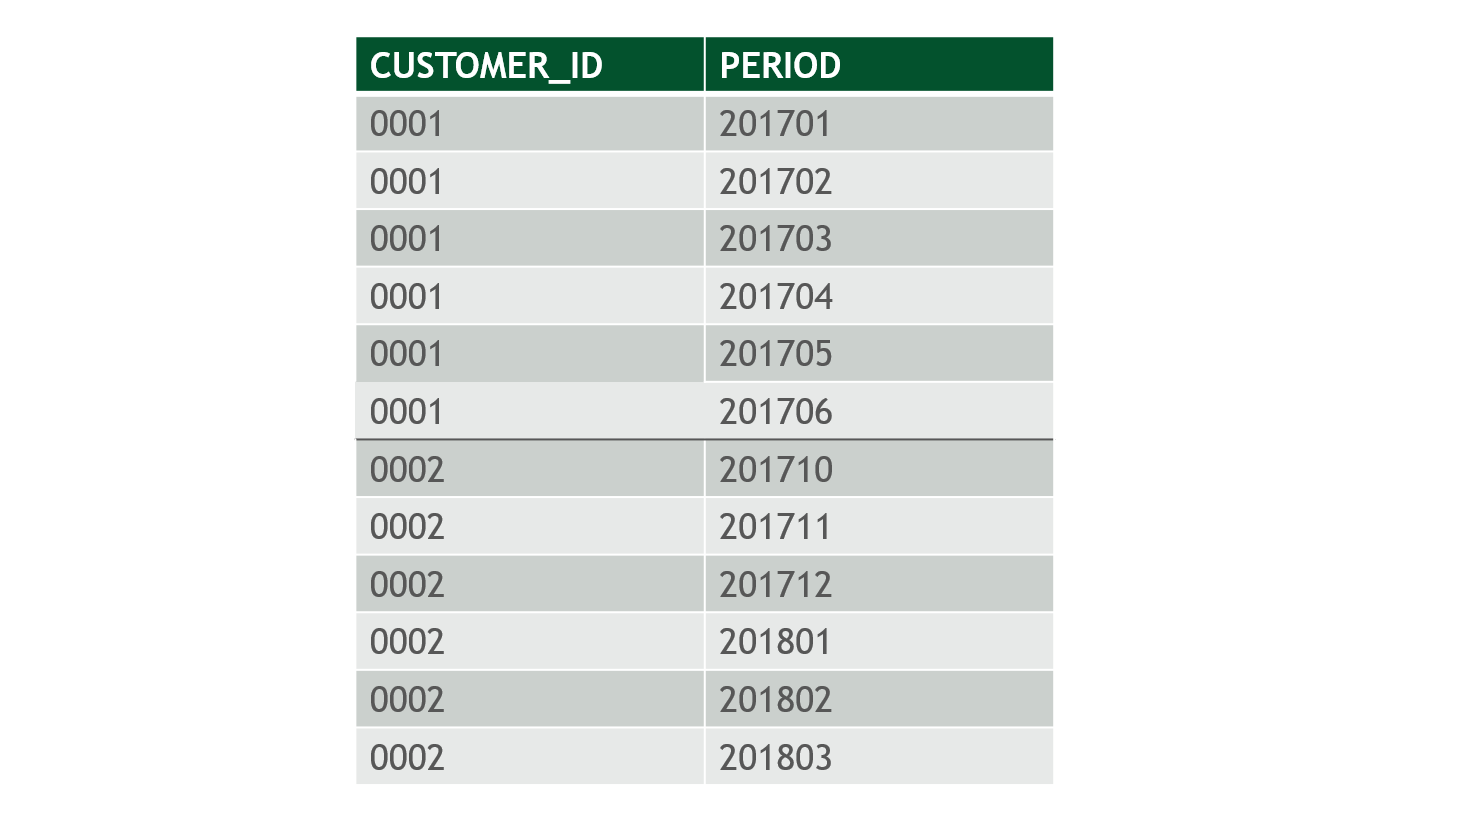

In [45]:
cust_base = cust_soft_churn[['CUSTOMER_ID', 'CUSTOMER_JOIN_DATE']]

In [46]:
cust_base['CUSTOMER_JOIN_DATE'] = pd.to_datetime(cust_base['CUSTOMER_JOIN_DATE'], format='%Y%m', errors='coerce')

In [47]:
cust_base_periods = pd.DataFrame(columns=['CUSTOMER_ID', 'PERIOD'])

new_rows = []
for i, row in cust_base.iterrows():
    for j in range(6):
        row['PERIOD'] = row['CUSTOMER_JOIN_DATE'] + pd.DateOffset(months=j)
        temp_df = pd.DataFrame({'CUSTOMER_ID':row['CUSTOMER_ID'], 
                                'PERIOD':row['PERIOD']}, index=[0])

        cust_base_periods = pd.concat([cust_base_periods, temp_df])

In [48]:
cust_base_periods['PERIOD'] = cust_base_periods['PERIOD'].apply(lambda x: x.strftime('%Y%m')).astype(int)
cust_base_periods['CUSTOMER_ID'] = cust_base_periods['CUSTOMER_ID'].astype(int)

#### View the resulting DataFrame with 6 period rows for each customer (with the first row reflecting the customer's join date)

In [49]:
cust_base_periods.head(18)

,CUSTOMER_ID,PERIOD
0,10315238,201701
0,10315238,201702
0,10315238,201703
0,10315238,201704
0,10315238,201705
0,10315238,201706
0,10316279,201701
0,10316279,201702
0,10316279,201703
0,10316279,201704


- With the above codes, we have created a DataFrame that contains each of the 6 initial periods for each customer. The purpose of this is to facilitate left joins later.
- Note that at this point, we have 2 DataFrames that we can use to capture further information of these 1890 customers: `cust_base` and `cust_base_periods`

In [50]:
# List of new joiner customers (1890 of them) whom we will be analyzing
cust_base.head(10)

,CUSTOMER_ID,CUSTOMER_JOIN_DATE
0,10315238,2017-01-01
1,10316279,2017-01-01
2,10319623,2017-01-01
3,10319739,2017-01-01
4,10320347,2017-01-01
5,10321652,2017-01-01
6,10323713,2017-01-01
7,10323927,2017-01-01
8,10324687,2017-01-01
9,10324935,2017-01-01


In [51]:
# Extended dataset with the 6 periods represented for each of the 1890 customers
cust_base_periods.head(12)

,CUSTOMER_ID,PERIOD
0,10315238,201701
0,10315238,201702
0,10315238,201703
0,10315238,201704
0,10315238,201705
0,10315238,201706
0,10316279,201701
0,10316279,201702
0,10316279,201703
0,10316279,201704


___

### Feature 1: Customer's Industry Sector
#### Let's start creating our first feature by exploring at the `funding` dataset. We earlier saw a column `SECTOR_L1` that reflects the high-level industry sector that the customer is from. It is a good feature to use as it reflects the profile of the customer.

In [52]:
# Obtain the industry sector of all customers
cust_sector = new_joiner_funds[['CUSTOMER_ID', 'SECTOR_L1']].drop_duplicates()
cust_sector.head()

,CUSTOMER_ID,SECTOR_L1
2069,10366474,Others ...
2070,10372601,Hospitality ...
2071,10375186,Manufactured Goods ...
2072,10375263,Manufactured Goods ...
2073,10372912,Services ...


#### Obtain the industry sector for each of the 1890 base customers
- We will use the `cust_base` DataFrame as the left table to capture the industry sector for each of them
- We store the resulting DataFrame as a new variable called `cust_features`, which we will use to continuously capture the predictor features we create

In [53]:
# Perform left join
cust_features = cust_base.merge(cust_sector,
                               on='CUSTOMER_ID',
                               how='left')

In [54]:
cust_features.head()

,CUSTOMER_ID,CUSTOMER_JOIN_DATE,SECTOR_L1
0,10315238,2017-01-01,Services ...
1,10316279,2017-01-01,Manufactured Goods ...
2,10319623,2017-01-01,Mining & Quarrying ...
3,10319739,2017-01-01,Non-Bank Financial Institutions ...
4,10320347,2017-01-01,Hospitality ...


#### (4.1) Drop the join date for now (in its raw form, it is not useful as a feature)
- Store the resulting output as the same variable name `cust_features`

In [55]:
# LEARNER TODO
cust_features = cust_features.drop(columns=['CUSTOMER_JOIN_DATE'])
cust_features.head()

,CUSTOMER_ID,SECTOR_L1
0,10315238,Services ...
1,10316279,Manufactured Goods ...
2,10319623,Mining & Quarrying ...
3,10319739,Non-Bank Financial Institutions ...
4,10320347,Hospitality ...


___
### Feature 2: Six-month mean CASA balance funding
#### The size of the average CASA fund in the first 6 months can be a useful feature to indicate the degree to which the banks utilize the CASA account. We perform a left join to bring the `PRE_6M_MEAN` column into our desired features.

In [56]:
cust_features_2 = cust_features.merge(cust_soft_churn[['CUSTOMER_ID', 'PRE_6M_MEAN']],
                                    on='CUSTOMER_ID',
                                    how='left')

In [57]:
cust_features_2.head()

,CUSTOMER_ID,SECTOR_L1,PRE_6M_MEAN
0,10315238,Services ...,5.665055e+06
1,10316279,Manufactured Goods ...,9.987000e+06
2,10319623,Mining & Quarrying ...,2.088438e+08
3,10319739,Non-Bank Financial Institutions ...,2.981871e+08
4,10320347,Hospitality ...,6.547267e+06


💭 **There are numerous other features that can be created**

For example:
- Starting balance value in the first month of joining
- Highest balance sum within the 6 month
- Month of joining (e.g.,Jan, Feb, Mar etc)

**Feel free to create additional features which you deem relevant**
___

### Feature 3 - Number of Active Loans with the bank
#### We now switch gears by looking at the `lending` dataset. A feature we can build is by obtaining the number of active loans that each customer has.

#### (4.2) Display the first 10 rows of the `lending` dataset which is sorted by the `CUSTOMER_ID` and `PERIOD` columns

In [58]:
# LEARNER TODO
lending.sort_values(by=['CUSTOMER_ID', 'PERIOD']).head(10)

,PERIOD,CUSTOMER_ID,ACCOUNT_ID,CL_MATURITY_DATE,CL_DIRECTORATE,GIRO_OVERDRAFT_FLAG,CR_OUTSTANDING
4790,201704,18208,35013161,12/2/2020 0:00,COMMERCIAL BANKING,0,8.270888e+09
9450,201705,18208,35013161,12/2/2020 0:00,COMMERCIAL BANKING,0,8.270888e+09
14655,201706,18208,35013161,12/2/2020 0:00,COMMERCIAL BANKING,0,8.270888e+09
24966,201707,18208,35013161,12/2/2020 0:00,COMMERCIAL BANKING,0,7.561954e+09
29811,201708,18208,35013161,12/2/2020 0:00,COMMERCIAL BANKING,0,7.561954e+09
34643,201709,18208,35013161,12/2/2020 0:00,COMMERCIAL BANKING,0,6.853021e+09
39680,201709,18208,35018600,23/4/2018 0:00,COMMERCIAL BANKING,0,9.998242e+08
45248,201710,18208,35018600,23/4/2018 0:00,COMMERCIAL BANKING,0,9.998242e+08
45955,201710,18208,35013161,12/2/2020 0:00,COMMERCIAL BANKING,0,6.853021e+09
55081,201711,18208,35013161,12/2/2020 0:00,COMMERCIAL BANKING,0,6.853021e+09


#### Merge the lending dataset with the `cust_base_periods` DataFrame (using left join)

In [59]:
lending_2 = cust_base_periods.merge(lending, 
                                    on=['CUSTOMER_ID', 'PERIOD'],
                                    how='left')

In [60]:
lending_2.head()

,CUSTOMER_ID,PERIOD,ACCOUNT_ID,CL_MATURITY_DATE,CL_DIRECTORATE,GIRO_OVERDRAFT_FLAG,CR_OUTSTANDING
0,10315238,201701,NaN,NaN,NaN,NaN,NaN
1,10315238,201702,NaN,NaN,NaN,NaN,NaN
2,10315238,201703,NaN,NaN,NaN,NaN,NaN
3,10315238,201704,NaN,NaN,NaN,NaN,NaN
4,10315238,201705,NaN,NaN,NaN,NaN,NaN


#### We want to first focus on customers with records of loans. It means we drop rows with NaNs.

In [61]:
# Drop NaNs to keep relevant active loans
lending_3 = lending_2.dropna()
lending_3

,CUSTOMER_ID,PERIOD,ACCOUNT_ID,CL_MATURITY_DATE,CL_DIRECTORATE,GIRO_OVERDRAFT_FLAG,CR_OUTSTANDING
285,10344637,201704,38930301.0,28/10/2017 0:00,COMMERCIAL BANKING,0.0,1.351630e+11
286,10344637,201704,39033402.0,5/11/2021 0:00,COMMERCIAL BANKING,0.0,4.741379e+10
287,10344637,201705,38930301.0,28/10/2017 0:00,COMMERCIAL BANKING,0.0,1.427810e+11
288,10344637,201705,39033402.0,5/11/2021 0:00,COMMERCIAL BANKING,0.0,4.655172e+10
289,10344637,201706,38930301.0,28/10/2017 0:00,COMMERCIAL BANKING,0.0,1.491240e+11
...,...,...,...,...,...,...,...
13520,12439739,201901,38838335.0,23/11/2033 0:00,SYARIAH BANKING,0.0,3.723120e+11
13521,12439739,201902,38838335.0,21/12/2033 0:00,SYARIAH BANKING,0.0,3.723120e+11
13522,12439739,201903,38838335.0,21/12/2033 0:00,SYARIAH BANKING,0.0,3.723120e+11
13523,12439739,201904,38838335.0,21/12/2033 0:00,SYARIAH BANKING,0.0,3.723120e+11


In [62]:
lending_3['CUSTOMER_ID'].nunique()

100

The above shows us that only 100 of the 1890 customers have at least 1 active loan with the bank

#### Get number of active loan accounts per customer

In [63]:
# Get number of active loan accounts per customer
cust_loan_count = lending_3[['CUSTOMER_ID', 'ACCOUNT_ID']].drop_duplicates().groupby(by='CUSTOMER_ID').count().reset_index()
cust_loan_count = cust_loan_count.rename(columns={'ACCOUNT_ID': 'ACTIVE_LOAN_COUNT'})
cust_loan_count = cust_loan_count.sort_values(by='ACTIVE_LOAN_COUNT', ascending=False)
cust_loan_count.head(10)

,CUSTOMER_ID,ACTIVE_LOAN_COUNT
57,11581321,183
41,11102225,110
77,12006432,68
56,11513862,41
27,10800470,39
48,11407161,31
70,11877032,30
72,11883795,29
58,11651394,25
83,12030174,25


#### Merge the number of active loans into the features DataFrame

In [64]:
cust_features_3 = cust_features_2.merge(cust_loan_count, 
                                        how='left',
                                        on='CUSTOMER_ID')

#### For customers without any active loans, we replace the NaN values as zero (to indicate 0 active loans)

In [65]:
# Fill NaN with 0 (indicates no active loan with bank)
cust_features_3 = cust_features_3.fillna(0)

💭 **There are numerous other features that can be created**

For example:
- Simple indicator of active loan - Boolean (T/F), instead of number of active loans
- Presence of GIRO overdraft - Boolean (T/F)
- Average outstanding loan amount across the 6 months - Float
- Maximum outstanding loan amount at any period - Float

**Feel free to create features that you feel may be relevant**

***

### Feature 4 - Transaction Trends
#### Let's now take a look at the `transactions` data, which reflects the customer's utilization patterns on their CASA bank account. In particular, we want to observe the trend of transactions for each customer over the 6 month period.

#### (4.3) Convert the `CUSTOMER_ID` and `ACCOUNT_ID` columns of the `transactions` dataset into integer type

In [66]:
# LEARNER TODO
# convert to int
dtype= {'CUSTOMER_ID': 'int64', 
        'ACCOUNT_ID' : 'int64'}

transactions = transactions.astype(dtype)
transactions.head(2)

,PERIOD,CUSTOMER_ID,ACCOUNT_ID,TRANSACTION_TYPE,VOLUME_TRANSACTED
0,201701,57396,6015162,Charges - D,30000.0030000.00
1,201701,87996,6132843,Bill Payment - D,4701618.004701618.00


#### (4.4) View the first 10 rows of the `transactions` data, and have a closer look at the `VOLUME_TRANSACTED` column. Do you notice anything strange?

In [67]:
# LEARNER TODO
transactions.head(10)

,PERIOD,CUSTOMER_ID,ACCOUNT_ID,TRANSACTION_TYPE,VOLUME_TRANSACTED
0,201701,57396,6015162,Charges - D,30000.0030000.00
1,201701,87996,6132843,Bill Payment - D,4701618.004701618.00
2,201701,124409,14954823,Charges - D,30000.0030000.00
3,201701,124409,14962971,Charges - D,30000.0030000.00
4,201701,159663,6022161,Overbooking - D,12000.0012000.00
5,201701,159737,5879860,Charges - D,65325.0065325.00
6,201701,159737,5883780,Bill Payment - D,27500.0027500.00
7,201701,159737,5883780,Incoming Trf - C,686829685.67686829685.67
8,201701,159737,5883780,Overbooking - D,6629385.006629385.00
9,201701,159737,6165681,Outgoing Trf - D,236182950.00236182950.00


#### We see that the `VOLUME_TRANSACTED` column has some errors in it. The same number is duplicated twice in a horizontal manner. It is something we need to clean up. The fastest way is to split the string at the . delimiter, and take the first integer value

In [68]:
# Clean up the decimal points in volume transacted (take the integer before first decimal point)
transactions['VOLUME_TRANSACTED_INT'] = transactions['VOLUME_TRANSACTED'].apply(lambda x: (x.split('.')[0]))

# Convert to integer type (Need to use np.int64 because the integer can be very large)
transactions['VOLUME_TRANSACTED_INT'] = transactions['VOLUME_TRANSACTED_INT'].astype(np.int64)

#### Merge the corresponding volume transacted data for the 1890 customers being analyzed

In [69]:
cust_trans = cust_base_periods.merge(transactions[['CUSTOMER_ID', 'PERIOD', 'VOLUME_TRANSACTED_INT']],
                                     on=['CUSTOMER_ID', 'PERIOD'],
                                     how='left')

#### Next, we get the average volume transacted at each month period for each customer.

In [70]:
# Get average volume transacted in each month
cust_trans = cust_trans.groupby(['CUSTOMER_ID', 'PERIOD']).mean().reset_index()

#### (4.5) There will be NaNs in the `VOLUME_TRANSACTED` column because some customers will not have any transactions performed. Therefore, we replace NaNs with zeroes
- HINT: Use `fillna(0)`

In [71]:
# Replace NaNs with zeros
cust_trans = cust_trans.fillna(0)

___

#### Earlier we mentioned we want to evaluate the trend of transactions over the 6 month period for each customers. The hypothesis here is that the trend of a customer's transactions over the 6 month period is a predictor of whether he/she will soft churn in the following 3 months. 

#### One way to assess this trend is to fit a best fit line (recall linear regression concepts) across the transaction volume over the 6 months, and retrieve the slope coefficient. If the slope coefficient is positive, it means that there is an upward trend of customer transactions with the bank, and vice versa.

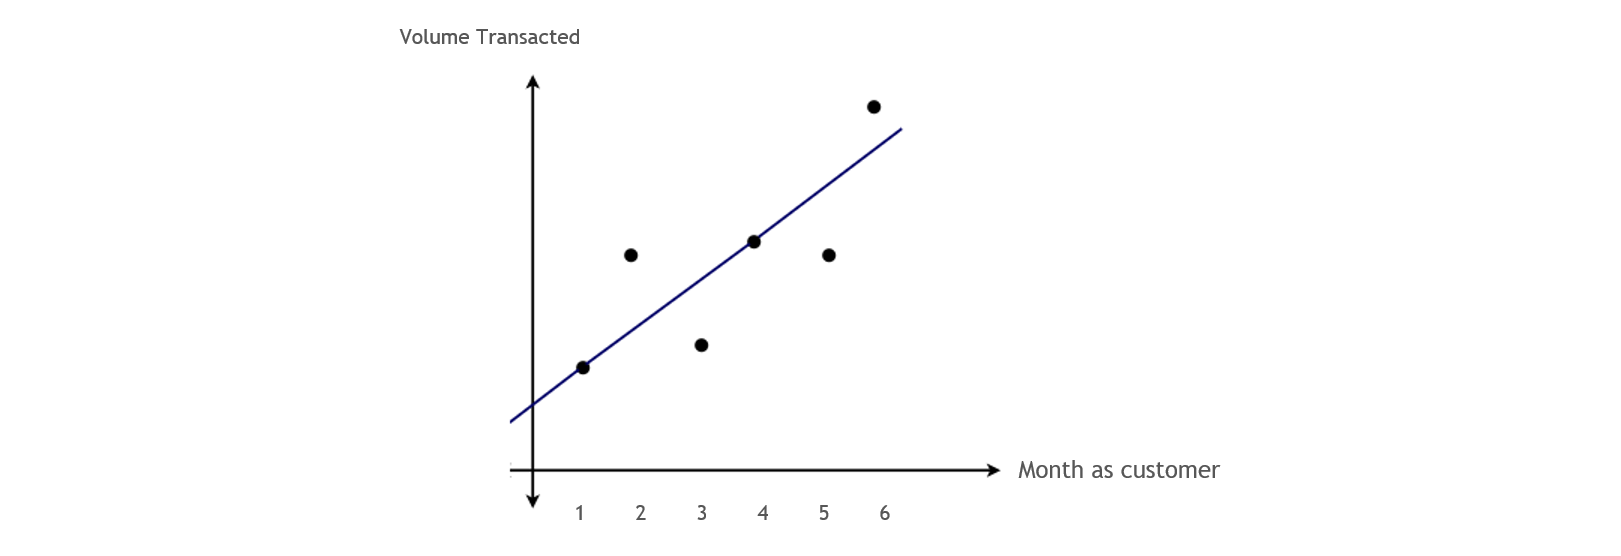

In [72]:
# Create a list to store all the slope coefficients (for all customers)
slope_values = []

In [73]:
# For each customer, retrieve the slope coefficient for the best fit line across the volume transacted over 6 months
for uid in cust_trans['CUSTOMER_ID'].unique():
    df = cust_trans[cust_trans['CUSTOMER_ID'] == uid]
    result = Polynomial.fit(x=[1,2,3,4,5,6],
                            y=list(df['VOLUME_TRANSACTED_INT'].values),
                            deg=1)
    slope = round(result.coef[1])
    slope_values.append(slope)

In [74]:
# Create new DataFrame of slope coefficient for each customer
cust_trans_trend = pd.DataFrame({'CUSTOMER_ID': cust_trans['CUSTOMER_ID'].unique(),
                                 'TRANSACTION_VOL_TREND': slope_values})
cust_trans_trend.head()

,CUSTOMER_ID,TRANSACTION_VOL_TREND
0,10315238,907676
1,10316279,929036
2,10319623,-13706388
3,10319739,0
4,10320347,0


In [75]:
# Merge feature with features dataframe
cust_features_4 = cust_features_3.merge(cust_trans_trend,
                                       on='CUSTOMER_ID',
                                       how='left')

In [76]:
cust_features_4.head()

,CUSTOMER_ID,SECTOR_L1,PRE_6M_MEAN,ACTIVE_LOAN_COUNT,TRANSACTION_VOL_TREND
0,10315238,Services ...,5.665055e+06,0.0,907676
1,10316279,Manufactured Goods ...,9.987000e+06,0.0,929036
2,10319623,Mining & Quarrying ...,2.088438e+08,0.0,-13706388
3,10319739,Non-Bank Financial Institutions ...,2.981871e+08,0.0,0
4,10320347,Hospitality ...,6.547267e+06,0.0,0


___
### Feature 5 - Customer Feedback
#### Finally, we take a look at the customers feedback dataset,

In [77]:
feedback.head()

,CUSTOMER_ID,PERIOD,FEEDBACK
0,6069045,201802,2
1,6410737,201911,4
2,5426241,201710,2
3,1044700,201711,4
4,6195462,201810,2


#### Because different customers can give different feedback scores at different periods, we want to narrow down to just the feedback provided within the first 6 months of each of the 1890 new joiners. As such, we perform a left join of the feedback data to the customer base periods `cust_base_periods` DataFrame

In [78]:
# Combine feedback data with customer base periods
cust_feedback_all = cust_base_periods.merge(feedback,
                                       on=['CUSTOMER_ID', 'PERIOD'],
                                       how='left')

#### (4.5) Find the proportion of the customer periods where there is no feedback
- HINT: Divide the number of NaN values in the feedback column, by the total number of rows

In [79]:
# LEARNER TODO
cust_feedback_all['FEEDBACK'].isna().sum() / cust_feedback_all.shape[0]

0.9828057490521118

- We can see from above that the feedback column is very sparse
- Nonetheless, for customers who gave at least 1 feedback, we want to get their average feedback scores.

In [80]:
# Filter to customers who gave at least 1 feedback within the initial 6 month window
cust_feedback = cust_feedback_all[~cust_feedback_all['FEEDBACK'].isna()]
cust_feedback = cust_feedback[['CUSTOMER_ID', 'FEEDBACK']].groupby(['CUSTOMER_ID']).mean().reset_index()

In [81]:
cust_feedback.head()

,CUSTOMER_ID,FEEDBACK
0,10315238,1.0
1,10330112,4.0
2,10335338,2.0
3,10337564,5.0
4,10343580,2.0


In [82]:
# Merge feedback scores into features
cust_features_5 = cust_features_4.merge(cust_feedback,
                                       on='CUSTOMER_ID',
                                       how='left')

#### (4.6) Replace the NaN values in the feedback column with the string ('None')

In [83]:
# LEARNER TODO
cust_features_5 = cust_features_5.fillna('None')

In [84]:
cust_features_5.sample(5)

,CUSTOMER_ID,SECTOR_L1,PRE_6M_MEAN,ACTIVE_LOAN_COUNT,TRANSACTION_VOL_TREND,FEEDBACK
1634,12118441,Services ...,2.159604e+08,0.0,12926013,None
213,10488870,Wholesale & Retail ...,5.190151e+07,0.0,450910329,None
1068,11501619,Others ...,1.443271e+10,0.0,-1533056983,None
119,10389798,Real Estate ...,2.374631e+08,0.0,0,None
261,10526897,Services ...,4.210633e+08,0.0,0,None


***

In [85]:
# additional features
# DONE - month joined
# starting balance within 1mo
# DONE - presence of giro overdraft
# max outstanding loan within 6mo
# highest balance within 6mo
# number of transactions within 6mo

In [86]:
# month joined
# use new_joiners dataframe because we only want to focus on customers within 2017-2018
month_joined = new_joiner_funds[['CUSTOMER_ID', 'CUSTOMER_JOIN_DATE']]
month_joined['CUSTOMER_JOIN_DATE'] = month_joined['CUSTOMER_JOIN_DATE'].apply(pd.to_datetime, format='%Y%m')

# check new df
month_joined.head()

,CUSTOMER_ID,CUSTOMER_JOIN_DATE
2069,10366474,2017-01-01
2070,10372601,2017-01-01
2071,10375186,2017-01-01
2072,10375263,2017-01-01
2073,10372912,2017-01-01


In [87]:
# check duplicated => shows that customers appear more than once
month_joined['CUSTOMER_ID'].duplicated().sum()

82675

In [88]:
# check that there is only 1 join date per customer ID
join_date_per_cid = month_joined.groupby('CUSTOMER_ID')['CUSTOMER_JOIN_DATE'] \
                                .agg(set) \
                                .reset_index(name = 'join_date_set')

join_date_per_cid['size'] = join_date_per_cid['join_date_set'].str.len()

In [89]:
# establish that there are no customers with more than 1 join date
join_date_per_cid[join_date_per_cid['size'] > 1]

,CUSTOMER_ID,join_date_set,size


In [90]:
# want only 1 instance of CID and the corresponding join date
month_joined = month_joined.groupby('CUSTOMER_ID')['CUSTOMER_JOIN_DATE'].first().reset_index()

# extract month part
month_joined['CUSTOMER_JOIN_DATE'] = month_joined['CUSTOMER_JOIN_DATE'].dt.strftime('%b')

# check changes
month_joined.head()

,CUSTOMER_ID,CUSTOMER_JOIN_DATE
0,10315238,Jan
1,10316279,Jan
2,10319623,Jan
3,10319739,Jan
4,10320347,Jan


In [91]:
# Merge month joined into features
cust_features_6 = cust_features_5.merge(month_joined,
                                        on='CUSTOMER_ID',
                                        how='left')

cust_features_6.head()

,CUSTOMER_ID,SECTOR_L1,PRE_6M_MEAN,ACTIVE_LOAN_COUNT,TRANSACTION_VOL_TREND,FEEDBACK,CUSTOMER_JOIN_DATE
0,10315238,Services ...,5.665055e+06,0.0,907676,1.0,Jan
1,10316279,Manufactured Goods ...,9.987000e+06,0.0,929036,None,Jan
2,10319623,Mining & Quarrying ...,2.088438e+08,0.0,-13706388,None,Jan
3,10319739,Non-Bank Financial Institutions ...,2.981871e+08,0.0,0,None,Jan
4,10320347,Hospitality ...,6.547267e+06,0.0,0,None,Jan


In [92]:
# presence of GIRO overdraft
giro = lending[['CUSTOMER_ID', 'GIRO_OVERDRAFT_FLAG']]

# check new df
giro.head()

,CUSTOMER_ID,GIRO_OVERDRAFT_FLAG
0,5413547,0
1,4043411,0
2,4043411,0
3,4043411,0
4,7393273,0


In [93]:
# check the total number of giro overdrafts per customer
giro_per_cid = giro.groupby('CUSTOMER_ID')['GIRO_OVERDRAFT_FLAG'] \
                   .agg(set) \
                   .reset_index(name = 'giro_set')

# sum of giro_set = 1 OR 0 = reflects whether customer has a giro overdraft or not
giro_per_cid['PRESENCE_GIRO_OVERDRAFT'] = giro_per_cid['giro_set'].apply(lambda x : sum(x))
giro_per_cid = giro_per_cid.drop('giro_set', axis=1)

# check changes
giro_per_cid.head()

,CUSTOMER_ID,PRESENCE_GIRO_OVERDRAFT
0,18208,0
1,39346,1
2,39614,0
3,105325,0
4,105453,0


In [94]:
# Merge month joined into features
cust_features_7 = cust_features_6.merge(giro_per_cid,
                                        on='CUSTOMER_ID',
                                        how='left')

cust_features_7 = cust_features_7.fillna(0)
# it's not meaningful to have 'None' in a column of 1/0
# if GRIO_PRESENCE is NaN, set to 0 to indicate no record of GIRO overdraft

In [95]:
cust_features_7.head()

,CUSTOMER_ID,SECTOR_L1,PRE_6M_MEAN,ACTIVE_LOAN_COUNT,TRANSACTION_VOL_TREND,FEEDBACK,CUSTOMER_JOIN_DATE,PRESENCE_GIRO_OVERDRAFT
0,10315238,Services ...,5.665055e+06,0.0,907676,1.0,Jan,0.0
1,10316279,Manufactured Goods ...,9.987000e+06,0.0,929036,None,Jan,0.0
2,10319623,Mining & Quarrying ...,2.088438e+08,0.0,-13706388,None,Jan,0.0
3,10319739,Non-Bank Financial Institutions ...,2.981871e+08,0.0,0,None,Jan,0.0
4,10320347,Hospitality ...,6.547267e+06,0.0,0,None,Jan,0.0


In [ ]:
# starting balance

In [ ]:
# highest balance

___
### Add Soft Churn Indicator target variable
- Now that we have a set of features we can use as predictors, we shall include our target variable (i.e., soft churn indicator) to form a complete dataset before train-test split

In [96]:
# Perform left join based on CUSTOMER_ID
df_customers = cust_features_7.merge(cust_soft_churn[['CUSTOMER_ID', 'SOFT_CHURN']],
                                    on='CUSTOMER_ID',
                                    how='left')

In [97]:
df_customers.sample(10)

,CUSTOMER_ID,SECTOR_L1,PRE_6M_MEAN,ACTIVE_LOAN_COUNT,TRANSACTION_VOL_TREND,FEEDBACK,CUSTOMER_JOIN_DATE,PRESENCE_GIRO_OVERDRAFT,SOFT_CHURN
1563,12030174,Manufactured Goods ...,1.131843e+08,25.0,500888981,None,Jul,0.0,0
657,10948600,Manufactured Goods ...,6.584971e+07,0.0,27877131,None,Jul,0.0,0
199,10483319,Manufactured Goods ...,4.535973e+07,0.0,17773358,None,Mar,0.0,0
265,10531723,"Telecommunication, Media & Technology ...",8.203333e+06,0.0,-1054286,None,Mar,0.0,0
1390,11796946,Construction ...,9.494738e+08,0.0,-2295952250,None,Apr,0.0,0
991,11419755,Others ...,9.931333e+06,0.0,0,None,Nov,0.0,0
1445,11868553,Services ...,2.093755e+09,0.0,-132190973,None,Apr,0.0,0
1224,11730081,Services ...,1.584267e+07,0.0,1465107,None,Mar,0.0,0
1726,12276850,Wholesale & Retail ...,2.761762e+07,0.0,209189821,None,Oct,0.0,0
185,10466884,Agriculture & Forestry ...,3.481439e+09,2.0,1764961996,None,Feb,0.0,1


In [98]:
df_customers = pd.get_dummies(df_customers)

In [99]:
df_customers = df_customers.rename(columns=lambda x: x.strip())

In [100]:
df_customers.head()

,CUSTOMER_ID,PRE_6M_MEAN,ACTIVE_LOAN_COUNT,TRANSACTION_VOL_TREND,PRESENCE_GIRO_OVERDRAFT,SOFT_CHURN,SECTOR_L1_Agriculture & Forestry,SECTOR_L1_Construction,SECTOR_L1_Hospitality,SECTOR_L1_Infrastructure,...,CUSTOMER_JOIN_DATE_Dec,CUSTOMER_JOIN_DATE_Feb,CUSTOMER_JOIN_DATE_Jan,CUSTOMER_JOIN_DATE_Jul,CUSTOMER_JOIN_DATE_Jun,CUSTOMER_JOIN_DATE_Mar,CUSTOMER_JOIN_DATE_May,CUSTOMER_JOIN_DATE_Nov,CUSTOMER_JOIN_DATE_Oct,CUSTOMER_JOIN_DATE_Sep
0,10315238,5.665055e+06,0.0,907676,0.0,1,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1,10316279,9.987000e+06,0.0,929036,0.0,1,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,10319623,2.088438e+08,0.0,-13706388,0.0,0,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,10319739,2.981871e+08,0.0,0,0.0,0,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,10320347,6.547267e+06,0.0,0,0.0,0,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False


___
## (5) Train Test Split

#### (5.1) Create the X and y datasets by dropping or keeping the target variable column

In [139]:
# LEARNER TODO
# define independent variables (features)
X = df_customers.drop('SOFT_CHURN', axis=1)

# define dependent variable
y = df_customers['SOFT_CHURN']

#### (5.2) Perform train test split
- Use ratio of train-test 80/20, and set random state as 1

In [140]:
# LEARNER TODO 
# stratifying due to class imbalance in outcome
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [141]:
print(X_train.shape)
print(X_test.shape)

(1512, 43)
(378, 43)


#### (5.3) At this point, the `CUSTOMER_ID` column is still in our X datasets. It is not a column that we should use for prediction, so we should drop it. Before that, store the `CUSTOMER_ID` column of the X_test DataFrame as a variable called `X_test_id` (which we will use later)

In [142]:
# LEARNER TODO
X_test_id = X['CUSTOMER_ID']

#### (5.4) Drop the `CUSTOMER_ID` column from both X_train and X_test DataFrames

In [143]:
# LEARNER TODO
X_train = X_train.drop('CUSTOMER_ID', axis=1)
X_test = X_test.drop('CUSTOMER_ID', axis=1)

In [146]:
# scaling
# scaling is required because we are using the knn model which is a distance-based model
# get numeric columns
num_col = X_train.select_dtypes(include=np.number).columns.tolist()

# scaler
scaler = MinMaxScaler()
X_train[num_col] = scaler.fit_transform(X_train[num_col])
X_test[num_col] = scaler.fit_transform(X_test[num_col])

___
## (6) Model Training and Hyperparameter Tuning

In [107]:
# goal: predict churn 3 months in advance

#### (6.1) With our train and test datasets ready, we can begin modeling along with hyperparameter tuning
- Based on what you have learnt, select a suitable algorithm to work with.
- For the algorithm selected, define the appropriate hyperparameter fields and ranges for the tuning process
- Do remember to incorporate cross validation in the process, and that the test set remains totally untouched
- At the end of this section, you should have fitted the model on the training dataset, and have a model ready to generate predictions

In [108]:
# LEARNER TODO
# in the interest of time and processing power - to use randomsearch instead of gridsearch
# im aware gridsearch is more thorough, but random search is faster when i have to rerun my code

# note: tried to use SVM but apparently SVM is not good for large (>100) datasets, so i gave up on it

In [150]:
# k nearest neighbours
# instantiate model
model = KNeighborsClassifier()

# define hyperparameters
hyperparameters = {'n_neighbors' : np.arange(2, 30, 1),
                   'weights'     : ['uniform','distance'],
                   'metric'      : ['minkowski','euclidean','manhattan'],
                   'algorithm'   : ['auto', 'ball_tree', 'kd_tree', 'brute'],
                   'p'           : [1, 2]}

# define scoring metrics
metrics = 'roc_auc'

# instantiate randomizedsearch
ran_knn = RandomizedSearchCV(model, hyperparameters, scoring=metrics, cv=10, refit='roc_auc', verbose = 1, n_jobs = -1)
ran_knn.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'metric': ['minkowski', 'euclidean',
                                                   'manhattan'],
                                        'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   refit='roc_auc', scoring='roc_auc', verbose=1)

In [151]:
# printing the best hyperparameters
print('The best hyper parameters are: \n',ran_knn.best_params_)

# scoring - best roc_auc score
ran_knn_best_score = ran_knn.best_score_
ran_knn_best_score

The best hyper parameters are: 
 {'weights': 'uniform', 'p': 2, 'n_neighbors': 27, 'metric': 'minkowski', 'algorithm': 'kd_tree'}


0.6234730410629193

In [152]:
# single decision tree
# instantiate model
model = DecisionTreeClassifier(random_state=42)

# define hyperparameters
hyperparameters = {'max_features'     : [1, 2, 5, 10, 15],
                   'max_depth'        : [5, 10, 15, 25, 30],
                   'min_samples_split': [2, 5, 10, 15, 100],
                   'min_samples_leaf' : [1, 2, 5, 10, 15],
                   'criterion'        : ["gini", "entropy"]
                  }

# define scoring metrics
metrics = 'roc_auc'

# instantiate randomizedsearch
ran_tree = RandomizedSearchCV(model, hyperparameters, scoring=metrics, cv=10, refit='roc_auc', verbose = 1, n_jobs = -1)
ran_tree.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 15, 25, 30],
                                        'max_features': [1, 2, 5, 10, 15],
                                        'min_samples_leaf': [1, 2, 5, 10, 15],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100]},
                   refit='roc_auc', scoring='roc_auc', verbose=1)

In [153]:
# printing the best hyperparameters
print('The best hyper parameters are: \n',ran_tree.best_params_)

# scoring - best roc_auc score
ran_tree_best_score = ran_tree.best_score_
ran_tree_best_score

The best hyper parameters are: 
 {'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 15, 'max_depth': 10, 'criterion': 'gini'}


0.6599670294215372

In [154]:
# random forest
# instantiate model
model = RandomForestClassifier(random_state=42)

# define hyperparameters
hyperparameters = {'n_estimators'     : [350, 400, 450, 500],
                   'max_features'     : ['auto', 'sqrt'],
                   'max_depth'        : [5, 10, 15, 25, 30],
                   'min_samples_split': [2, 5, 10, 15, 100],
                   'min_samples_leaf' : [1, 2, 5, 10, 15],
                   'bootstrap'        : [True, False]
                  }

# define scoring metrics
metrics = 'roc_auc'

# instantiate randomizedsearch
ran_rf = RandomizedSearchCV(model, hyperparameters, scoring=metrics, cv=10, refit='roc_auc', verbose = 1, n_jobs = -1)
ran_rf.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10, 15],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [350, 400, 450, 500]},
                   refit='roc_auc', scoring='roc_auc', verbose=1)

In [155]:
# Printing the best hyperparameters
print('The best hyper parameters are: \n',ran_rf.best_params_)

# scoring
ran_rf_best_score = ran_rf.best_score_
ran_rf_best_score

The best hyper parameters are: 
 {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25, 'bootstrap': False}


0.6777174452575448

In [156]:
# xgboost
# instantiate the classifier
model = xgb.XGBClassifier(random_state=42)

# create a dictionary of hyperparameters to tune 
hyperparameters = {'n_estimators' : [200, 300, 400, 500],
                   'max_depth'    : [2, 4, 5, 10, 15, 25],
                   'learning_rate': [0.01, 0.05, 0.1, 1]
                  }

# define scoring metrics
metrics = 'roc_auc'

# instantiate randomizedsearch
ran_xgb = RandomizedSearchCV(model, hyperparameters, scoring=metrics, cv=10, refit='roc_auc', verbose = 1, n_jobs = -1)
ran_xgb.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 1],
                                        'max_depth': [2, 4, 5, 10, 15, 25],
                                        'n_estimators': [200, 300, 400, 500]},
                   refit='roc_auc', scoring='roc_auc', verbose=1)

In [157]:
# Printing the best hyperparameters
print('The best hyper parameters are: \n',ran_xgb.best_params_)

# scoring
ran_xgb_best_score = ran_xgb.best_score_
ran_xgb_best_score

The best hyper parameters are: 
 {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01}


0.7285043781808163

In [158]:
# catboost
# instantiate the classifier
model = CatBoostClassifier(random_state=42)

# create a dictionary of hyperparameters to tune 
hyperparameters = {'n_estimators' : [200, 300, 400, 500],
                   'learning_rate': np.linspace(0,0.2,5),
                   'depth'        : [6, 7, 8, 9, 10],
                   'l2_leaf_reg'  : [3, 4, 5]}

# define scoring metrics
metrics = 'roc_auc'

# instantiate randomizedsearch
ran_cat = RandomizedSearchCV(model, hyperparameters, scoring=metrics, cv=10, refit='roc_auc', verbose = 1, n_jobs = -1)
ran_cat.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
0:	learn: 0.6528142	total: 28.5ms	remaining: 11.4s
1:	learn: 0.6236959	total: 58.1ms	remaining: 11.6s
2:	learn: 0.6026564	total: 72.1ms	remaining: 9.54s
3:	learn: 0.5843562	total: 98.8ms	remaining: 9.78s
4:	learn: 0.5699385	total: 128ms	remaining: 10.1s
5:	learn: 0.5582505	total: 156ms	remaining: 10.2s
6:	learn: 0.5447120	total: 187ms	remaining: 10.5s
7:	learn: 0.5336447	total: 217ms	remaining: 10.6s
8:	learn: 0.5221142	total: 246ms	remaining: 10.7s
9:	learn: 0.5143271	total: 270ms	remaining: 10.5s
10:	learn: 0.5059120	total: 293ms	remaining: 10.4s
11:	learn: 0.5026064	total: 299ms	remaining: 9.68s
12:	learn: 0.4987795	total: 318ms	remaining: 9.46s
13:	learn: 0.4952605	total: 328ms	remaining: 9.04s
14:	learn: 0.4884950	total: 352ms	remaining: 9.04s
15:	learn: 0.4834770	total: 375ms	remaining: 8.99s
16:	learn: 0.4811298	total: 378ms	remaining: 8.52s
17:	learn: 0.4802264	total: 383ms	remaining: 8.13s
18:	learn: 0.4760036	tota

166:	learn: 0.2071659	total: 4.18s	remaining: 5.83s
167:	learn: 0.2067982	total: 4.2s	remaining: 5.8s
168:	learn: 0.2054654	total: 4.23s	remaining: 5.78s
169:	learn: 0.2046236	total: 4.25s	remaining: 5.75s
170:	learn: 0.2033706	total: 4.27s	remaining: 5.72s
171:	learn: 0.2025327	total: 4.3s	remaining: 5.7s
172:	learn: 0.2012464	total: 4.32s	remaining: 5.67s
173:	learn: 0.2004107	total: 4.34s	remaining: 5.64s
174:	learn: 0.1991563	total: 4.37s	remaining: 5.62s
175:	learn: 0.1976945	total: 4.4s	remaining: 5.6s
176:	learn: 0.1967652	total: 4.43s	remaining: 5.58s
177:	learn: 0.1956726	total: 4.45s	remaining: 5.55s
178:	learn: 0.1947513	total: 4.48s	remaining: 5.53s
179:	learn: 0.1940378	total: 4.5s	remaining: 5.5s
180:	learn: 0.1931194	total: 4.53s	remaining: 5.48s
181:	learn: 0.1919037	total: 4.55s	remaining: 5.45s
182:	learn: 0.1912539	total: 4.58s	remaining: 5.43s
183:	learn: 0.1906209	total: 4.61s	remaining: 5.41s
184:	learn: 0.1897610	total: 4.63s	remaining: 5.38s
185:	learn: 0.188954

327:	learn: 0.1121767	total: 8.11s	remaining: 1.78s
328:	learn: 0.1116741	total: 8.14s	remaining: 1.75s
329:	learn: 0.1112581	total: 8.16s	remaining: 1.73s
330:	learn: 0.1108905	total: 8.19s	remaining: 1.71s
331:	learn: 0.1106237	total: 8.21s	remaining: 1.68s
332:	learn: 0.1103911	total: 8.23s	remaining: 1.66s
333:	learn: 0.1101779	total: 8.26s	remaining: 1.63s
334:	learn: 0.1100609	total: 8.28s	remaining: 1.61s
335:	learn: 0.1097042	total: 8.31s	remaining: 1.58s
336:	learn: 0.1093216	total: 8.33s	remaining: 1.56s
337:	learn: 0.1089501	total: 8.35s	remaining: 1.53s
338:	learn: 0.1086130	total: 8.38s	remaining: 1.51s
339:	learn: 0.1080234	total: 8.41s	remaining: 1.48s
340:	learn: 0.1077369	total: 8.44s	remaining: 1.46s
341:	learn: 0.1075092	total: 8.46s	remaining: 1.44s
342:	learn: 0.1073702	total: 8.49s	remaining: 1.41s
343:	learn: 0.1071523	total: 8.5s	remaining: 1.38s
344:	learn: 0.1066408	total: 8.52s	remaining: 1.36s
345:	learn: 0.1063831	total: 8.54s	remaining: 1.33s
346:	learn: 0

RandomizedSearchCV(cv=10,
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000022D00141AD0>,
                   n_jobs=-1,
                   param_distributions={'depth': [6, 7, 8, 9, 10],
                                        'l2_leaf_reg': [3, 4, 5],
                                        'learning_rate': array([0.  , 0.05, 0.1 , 0.15, 0.2 ]),
                                        'n_estimators': [200, 300, 400, 500]},
                   refit='roc_auc', scoring='roc_auc', verbose=1)

In [159]:
# Printing the best hyperparameters
print('The best hyper parameters are: \n',ran_cat.best_params_)

# scoring
ran_cat_best_score = ran_cat.best_score_
ran_cat_best_score

The best hyper parameters are: 
 {'n_estimators': 400, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'depth': 10}


0.7022188219229148

In [160]:
score_matrix = pd.DataFrame({'Model' : ['K-Nearest Neighbours', 'Decision Tree', 'Random Forest', 'XGBoost', 'CatBoost'],
                             'Model ROC_AUC Score' : [ran_knn_best_score, ran_tree_best_score, ran_rf_best_score, ran_xgb_best_score, ran_cat_best_score]})

score_matrix

,Model,Model ROC_AUC Score
0,K-Nearest Neighbours,0.623473
1,Decision Tree,0.659967
2,Random Forest,0.677717
3,XGBoost,0.728504
4,CatBoost,0.702219


___
## (7) Generate Predictions

#### (7.1) With your best model from the previous section, generate two sets of prediction output from the test set (X_test)
- Prediction probabilities (save it as an array in a new variable named `y_preds_proba`
- Label predictions (save it as an array in a new variable named `y_preds`

In [161]:
# fit best model with best hyperparameters
xgb_finalmodel = ran_xgb.best_estimator_.fit(X_train,y_train)

In [162]:
# LEARNER TODO
# prediction probability (need 2)
y_preds_proba = xgb_finalmodel.predict_proba(X_test)

In [163]:
# get predictions from test set (need 2)
y_preds = xgb_finalmodel.predict(X_test)

___
## (8) Model Evaluation

#### (8.1) Using the predictions and the true values in the test set, evaluate the model performance by calculating the following metrics (rounded to 2 decimal places)
- Accuracy
- F1 score
- ROC-AUC Score
- AUC-PR Score (aka Average Precision Score)

In [164]:
# accuracy
print("xgb accuracy: ", round(accuracy_score(y_test, y_preds),2))

xgb accuracy:  0.72


In [165]:
# f1 score
print("xgb f1 score: ", round(f1_score(y_test, y_preds),2))

xgb f1 score:  0.16


In [166]:
# roc_auc score
print("xgb roc_auc score: ", round(roc_auc_score(y_test, y_preds_proba[:,1]),2))

xgb roc_auc score:  0.57


In [167]:
# auc-pr score
print("xgb auc_pr score: ", round(average_precision_score(y_test, y_preds_proba[:,1]),2))

xgb auc_pr score:  0.34


In [168]:
# classification report
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_preds, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.75      0.94      0.83       280
    Predicted would leave       0.36      0.10      0.16        98

                 accuracy                           0.72       378
                macro avg       0.55      0.52      0.50       378
             weighted avg       0.65      0.72      0.66       378



#### (8.2) Generate a confusion matrix of the predictions
- HINT: Use `ConfusionMatrixDisplay.from_predictions()` for a better visualization of the confusion matrix

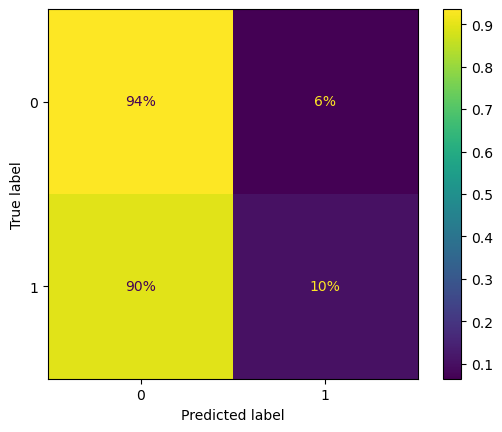

In [170]:
# LEARNER TODO
# Generate array of values for confusion matrix
cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_preds, normalize="true", values_format=".0%")
plt.show()

#### Calculate the percentages of false positives and false negatives

In [172]:
# % of FP and FN in output
conf_mat = confusion_matrix(y_test, y_preds)

print(f"% of True Positive: {conf_mat[1][1]*100/(conf_mat[0][0] + conf_mat[0][1] + conf_mat[1][0] + conf_mat[1][1])}")
print(f"% of True Negative: {conf_mat[0][0]*100/(conf_mat[0][0] + conf_mat[0][1] + conf_mat[1][0] + conf_mat[1][1])}")
print(f"% of False Positive: {conf_mat[0][1]*100/(conf_mat[0][0] + conf_mat[0][1] + conf_mat[1][0] + conf_mat[1][1])}")
print(f"% of False Negative: {conf_mat[1][0]*100/(conf_mat[0][0] + conf_mat[0][1] + conf_mat[1][0] + conf_mat[1][1])}\n")

% of True Positive: 2.6455026455026456
% of True Negative: 69.31216931216932
% of False Positive: 4.761904761904762
% of False Negative: 23.280423280423282



#### (8.3) (OPTIONAL) Generate the feature importance plot if your algorithm of choice is able to do so

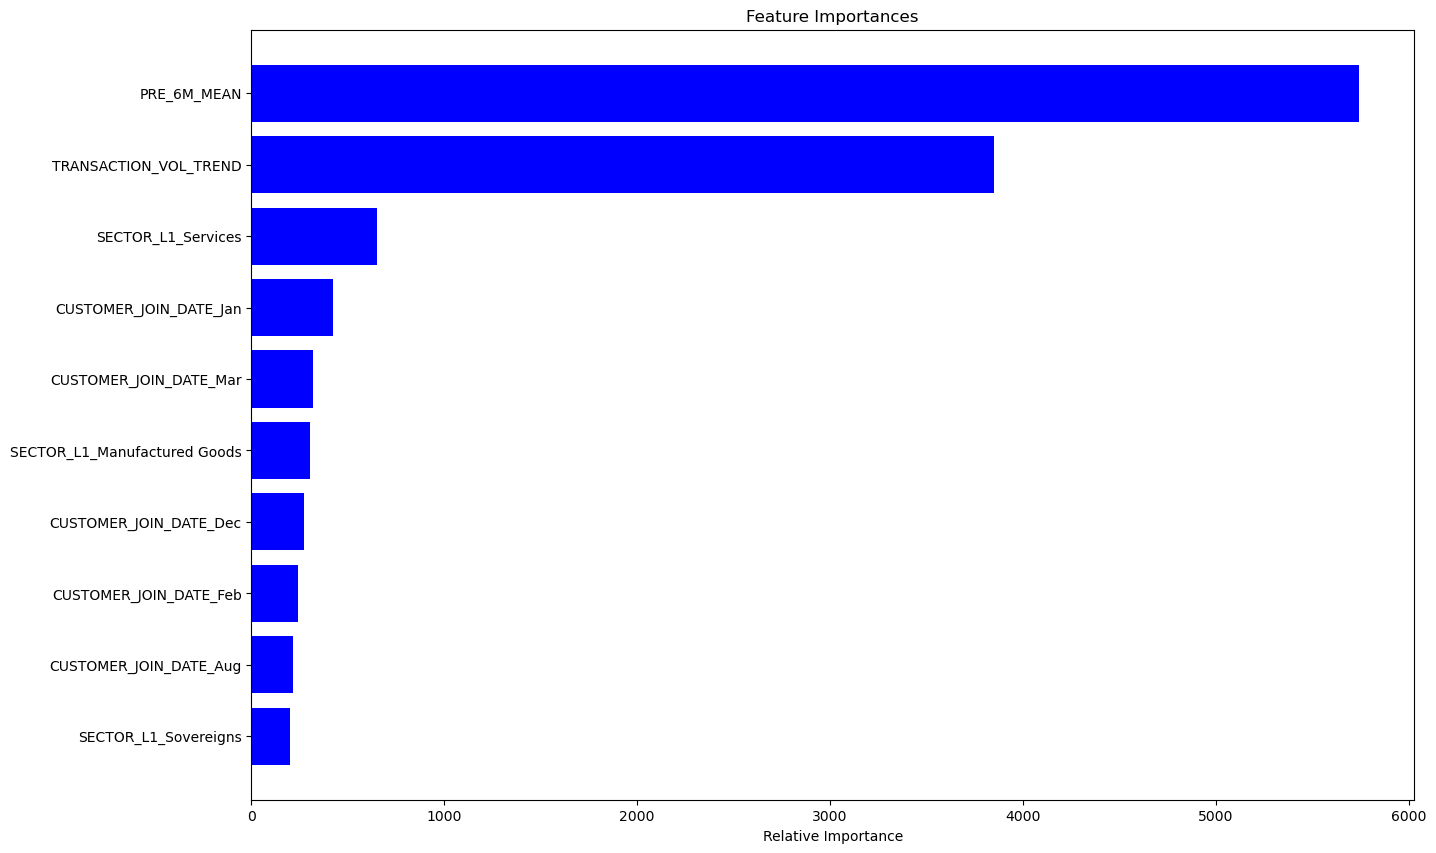

In [173]:
# LEARNER TODO
# feature importance plot - xgboost
feature_important = xgb_finalmodel.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).nlargest(10, columns='score').sort_values(by="score", ascending=True)

plt.figure(figsize=(15,10))
plt.title('Feature Importances')
plt.barh(data.index, data['score'], color='b', align='center')
plt.xlabel('Relative Importance')
plt.show()

#### NOTE: Feel free to experiment with different algorithms for Sections 7 and 8

___
## (9) Recommendations

#### (9.1) Now that we have the predicted probability of soft churn for each customer, we want to leverage this information to provide concrete recommendations to the business. For instance, the prediction of churn probability allows to concentrate actions on the most probable churners.

#### Firstly, we create a DataFrame with the soft churn propensity for each customer ID. 
- HINT: Use `y_preds_proba` and `X_test_id` series which you have saved earlier

In [131]:
# LEARNER TODO
pred = y_preds_proba[0]
pred = pd.DataFrame(pred)
pred = pred.iloc[:,1:]
xgb_outdata = pd.concat([X_test_id, pred], axis=1).rename(columns={1:'CHURN_PROPENSITY'})
xgb_outdata.head()

,CUSTOMER_ID,CHURN_PROPENSITY
0,10315238,0.138482
1,10316279,0.149918
2,10319623,0.161751
3,10319739,0.138482
4,10320347,0.168013


#### (9.2) Store the top 10 customers with the highest churn propensity as a separate DataFrame called `churn_top_10`
- HINT: Use `.sort_values()` and `.head(10)`

In [132]:
churn_top_10 = xgb_outdata.nlargest(10, 'CHURN_PROPENSITY')
churn_top_10.head()

,CUSTOMER_ID,CHURN_PROPENSITY
179,10460560,0.894461
95,10374828,0.857377
276,10554152,0.846051
26,10333914,0.744453
148,10433892,0.686428


#### Business Considerations
- At this juncture, it may seem like that the task is complete, since we have found the list of top 10 customers who are most likely to soft churn
- However, from the business point of view, not all customers are equally valuable. As such, it makes more sense to prioritize efforts to 'keep' the likely churners who offer more business value to the bank.
- There are many different ways to gauge how valuable a customer is. For our project here, we can just use the simple metric of average CASA account balance (in the first 6 months) as a measure of the customer's value.
- To do this, we first merge the `PRE_6M_MEAN` column into our `churn_top_10` DataFrame to get the average 6-month balance for each customer along with the soft churn propensity.

In [133]:
churn_top_10  = churn_top_10.merge(cust_soft_churn[['CUSTOMER_ID', 'PRE_6M_MEAN']],
                                    on=['CUSTOMER_ID'],
                                    how='left')

In [134]:
# Display first 10 rows
churn_top_10.head(10)

,CUSTOMER_ID,CHURN_PROPENSITY,PRE_6M_MEAN
0,10460560,0.894461,5.696315e+07
1,10374828,0.857377,1.670227e+07
2,10554152,0.846051,9.653667e+06
3,10333914,0.744453,5.551249e+05
4,10433892,0.686428,5.126389e+09
5,10435652,0.636745,1.032143e+09
6,10343154,0.619080,2.301504e+08
7,10639937,0.615606,1.671224e+08
8,10662276,0.591693,8.551129e+07
9,10645719,0.589274,4.000000e+04


#### (9.3) In our final step, we calculate what is the expected loss value if the customer eventually does a hard churn.
- HINT: We can do this by creating a new column that multiplies the propensity with the average CASA balance
- Once created, we can then re-sort the top 10 list and display who are the 5 corporate customers that the bank should highly 
prioritize on keeping

In [135]:
# LEARNER TODO
churn_top_10['EXPECTED_LOSS'] = churn_top_10['CHURN_PROPENSITY'] * churn_top_10['PRE_6M_MEAN']
churn_top_10 = churn_top_10.sort_values(by='EXPECTED_LOSS', ascending=False)

In [136]:
churn_top_10.head()

,CUSTOMER_ID,CHURN_PROPENSITY,PRE_6M_MEAN,EXPECTED_LOSS
4,10433892,0.686428,5.126389e+09,3.518897e+09
5,10435652,0.636745,1.032143e+09,6.572123e+08
6,10343154,0.619080,2.301504e+08,1.424816e+08
7,10639937,0.615606,1.671224e+08,1.028815e+08
0,10460560,0.894461,5.696315e+07,5.095134e+07


___
### Final Notes
- The above example is a straightforward demonstration of how a soft churn model can be trained and used to generate churn probabilities.
- As mentioned earlier, there is plenty of ways to further improve the model performance, and most of the improvement will be driven by the quality of data and features used.
- The following diagram is an illustration of the wide range of data fields that can be used as part of a more sophisticated churn prediction model:

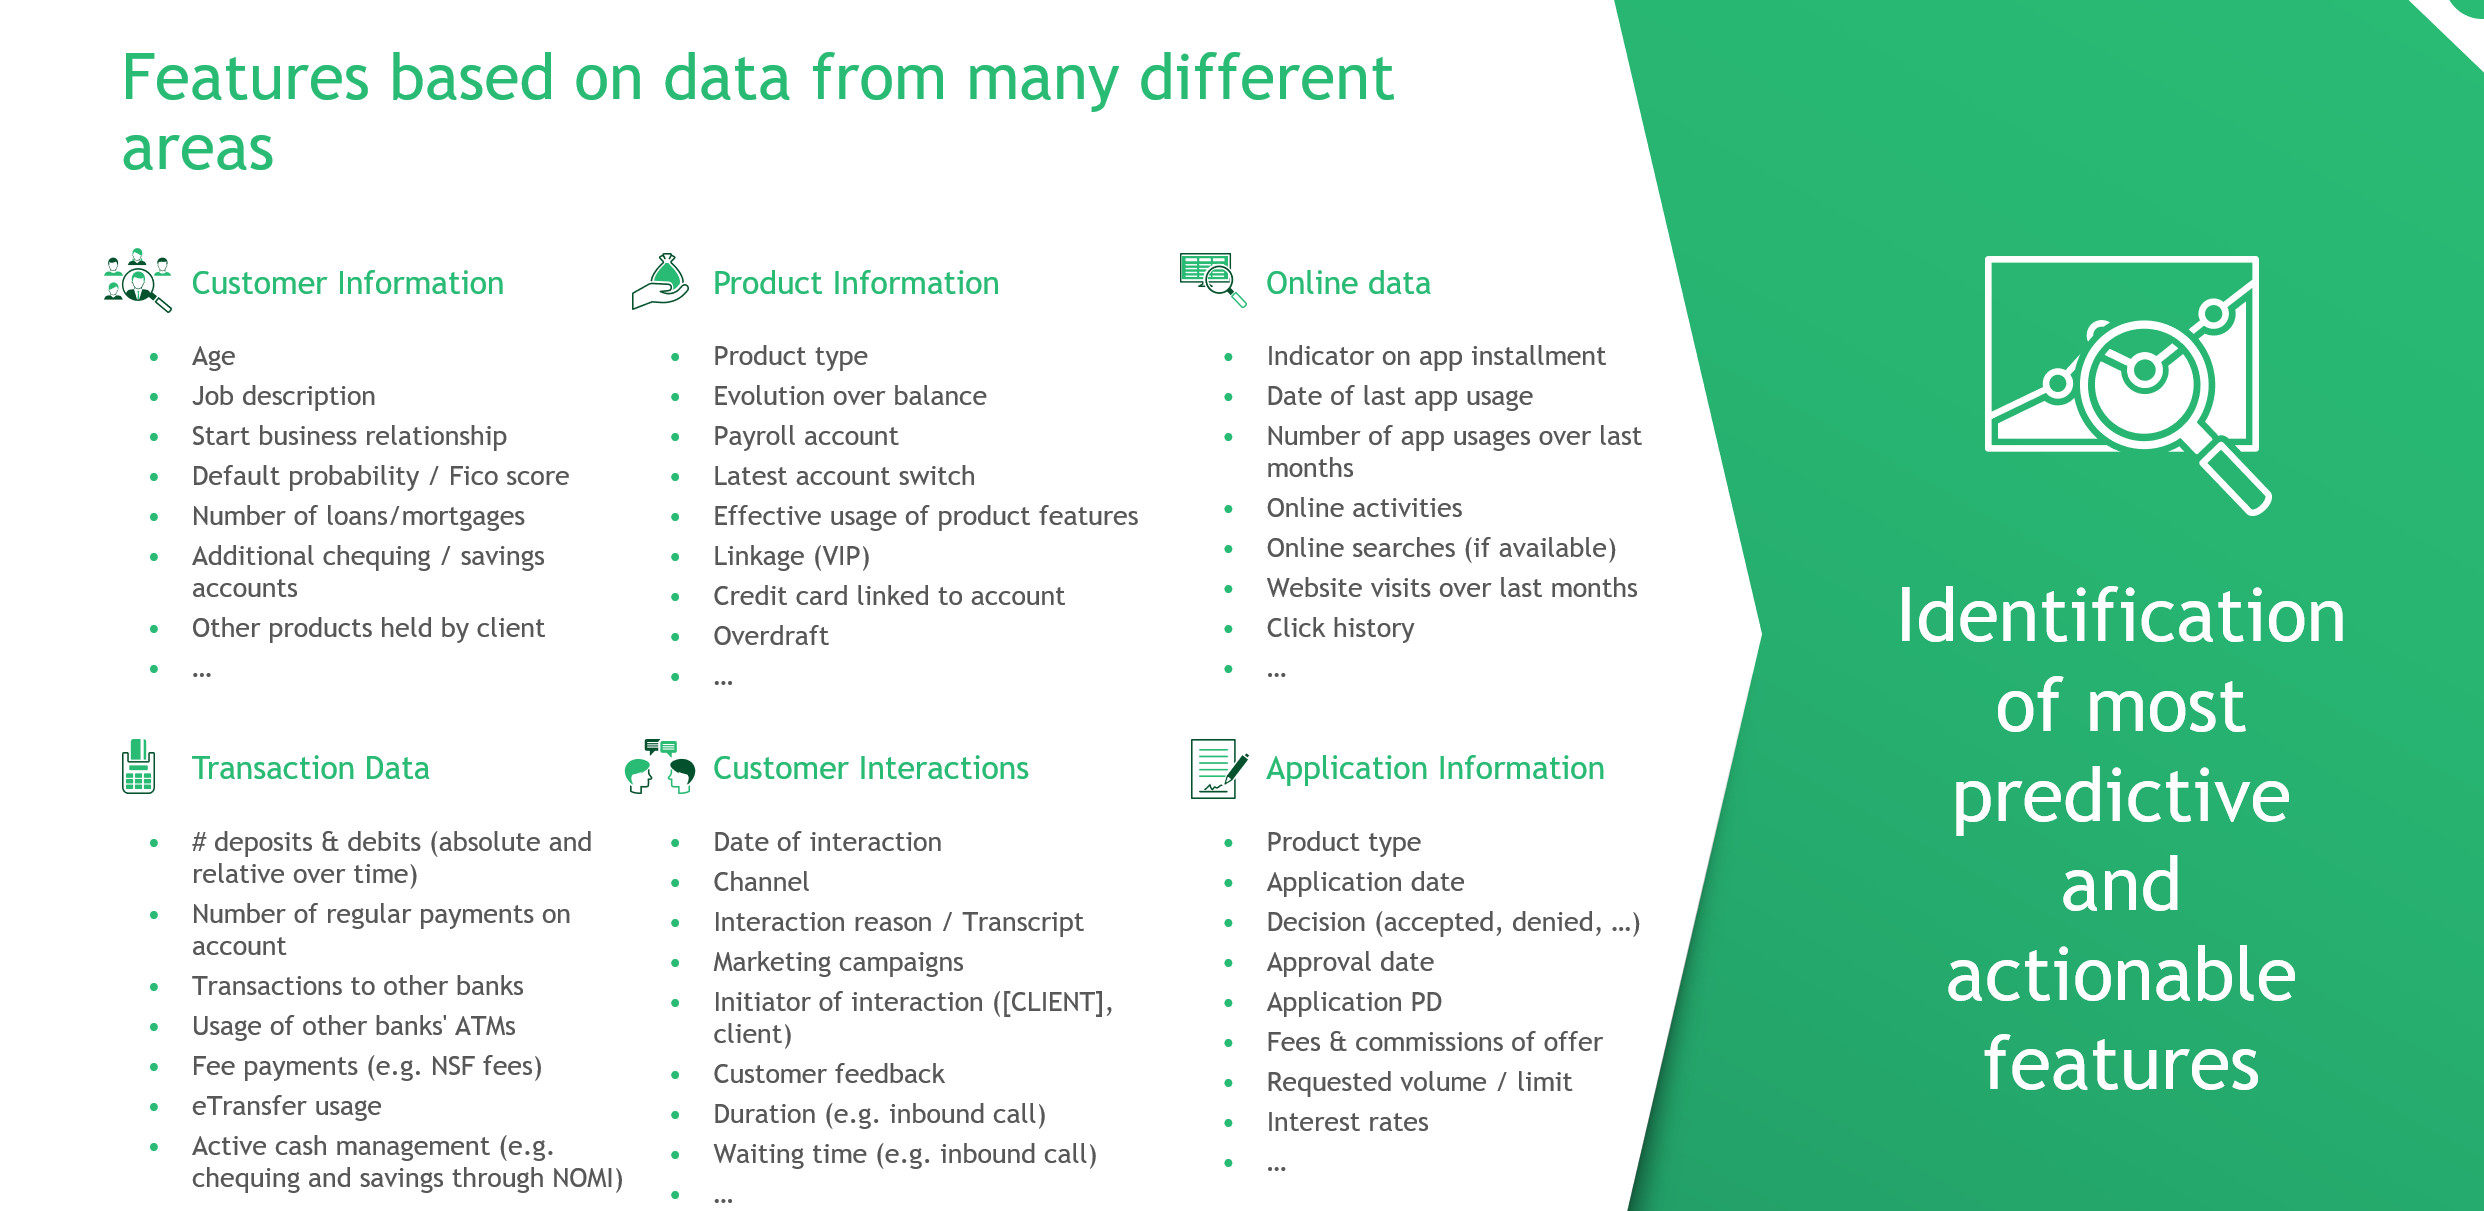

___
### Further Reading (Advanced)
- https://scikit-learn.org/stable/modules/permutation_importance.html#relation-to-impurity-based-importance-in-trees
- https://towardsdatascience.com/pythons-predict-proba-doesn-t-actually-predict-probabilities-and-how-to-fix-it-f582c21d63fc